# Emotion Recognition from Faces with CNN - Training & Evaluation - Part 2

In this series we will continue builind a model that will guess the emotion of a person from a facial expression. We will add techniques such as batch normalization and hyperparameters tuning, and add layers to make more advance models compared to part one.

The model will be trained only with the seven basic emtotions identified by Ekman: anger, disgust, contempt, happiness, sadness, fear, surprise.

Moreover, the model will look only at photos of real people (no cartoon or generated images), to capture microexpressions, which are crucual to give high accuracy to such a model. In fact, humans heavily rely on microexpressions to distinguish between different emotions in the arc of milliseconds (e.g., fear from surprise, disgust from contempt), and taking those out of the equations would mean removing key elememnts. A challenge might be increasing the quality of the images used for training, then burdening the computational power with an heavier dataset. Feature engineering might be key in selecting the parts of the images that are the most relevant, eliminating everything else.

Finally we will build different Convolutional Neural Networks and evaluate the different models. Since the whole process will take a significant amount of code, the work will be divided into different notebooks linking to each other.

The first notebook focused in loading, cleaning, and augmenting the data. Whereas the first part of the modelling testes different combinations of models and make observations.
- [Emotion Recognition from Faces with CNN - Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-eda)
- [Emotion_Classification_from_Faces_with_CNN_Part_1](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-pytorch-1)

This second notebook of the series will focus on builidng deep neaural networks with Pytorch. After that we will train, test, and evaluate the models to select what we think is the best in detecting emotions from facial expressions. After saving the model we will drive some conclusions, underline the limitations of the model, and outline the next steps.

Happy modelling!

## Table of contents

1. [Load the libraries](#load-the-data)
2. [Load the data](#load-the-libraries)
3. [Split the data](#split-the-data)
4. [Build the models](#build-the-models)    
5. [Train and test the models](#train-and-test-the-models)

    5.1 [Define the hyperparameters](#define-the-hyperparameters)

    5.2 [Helper functions for training, testing, and plotting](#helper-functions-for-training-testing-and-plotting)
    
    5.3 [Train the models](#train-the-models)
    
    5.4 [Test the models](#test-the-models)

    5.5 [Table with the results of the different models](#table-with-the-results-of-the-different-models)

    5.6 [Confusion matrix of the best model](#confusion-matrix-of-the-best-model)

6. [Conclusions](#conclusions)

    6.1 [Observations](#observations)

    6.2 [Lessons learned](#lessons-learned)

    6.3 [Limitations with the data](#limitations-with-the-data)

    6.4 [Next steps](#next-steps)

## Load the libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle
import random
from hashlib import md5
import matplotlib.pyplot as plt
import copy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

## Load the data

In [2]:
# Load the data from a pickle file
balanced_data = pd.read_pickle('balanced_images_labels.pkl')

Show the properties of the data to assure the data has been loaded correctly.

In [6]:
#See how many elements we have for each class, like we did in the previous notebook.
def count_items_in_classes_2(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        balanced_img_data_dict = pickle.load(f)

    # Count the number of items in each class
    for label, img_list in balanced_img_data_dict.items():
        print(f'{label}: {len(img_list)} images')

In [7]:
# Specify the input dataset file
dataset_file = 'balanced_images_labels.pkl'

# Execute the verification function
count_items_in_classes_2(dataset_file)

Neutral: 9111 images
Sadness: 9111 images
Surprise: 9111 images
Happiness: 9111 images
Anger: 9111 images
Fear: 9111 images
Disgust: 9111 images
Contempt: 9111 images


In [8]:
#Inspect the shape of the data
def inspect_balanced_dataset(file_path):
    # Load the balanced dataset
    with open(file_path, 'rb') as f:
        balanced_img_data_dict = pickle.load(f)
    
    # Initialize lists to collect all images and labels
    all_images = []
    all_labels = []

    # Iterate through the dictionary to collect data
    for label, img_list in balanced_img_data_dict.items():
        all_images.extend(img_list)
        all_labels.extend([label] * len(img_list))
    
    # Convert lists to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    
    # Print the required information
    print(f'Loaded data shape: {all_images.shape}')
    print(f'Loaded labels shape: {all_labels.shape}')
    print(f'Unique labels: {set(all_labels)}')

# Specify the input dataset file
dataset_file = 'balanced_images_labels.pkl'

# Execute the inspection function
inspect_balanced_dataset(dataset_file)

Loaded data shape: (72888, 48, 48)
Loaded labels shape: (72888,)
Unique labels: {'Surprise', 'Disgust', 'Neutral', 'Fear', 'Anger', 'Sadness', 'Contempt', 'Happiness'}


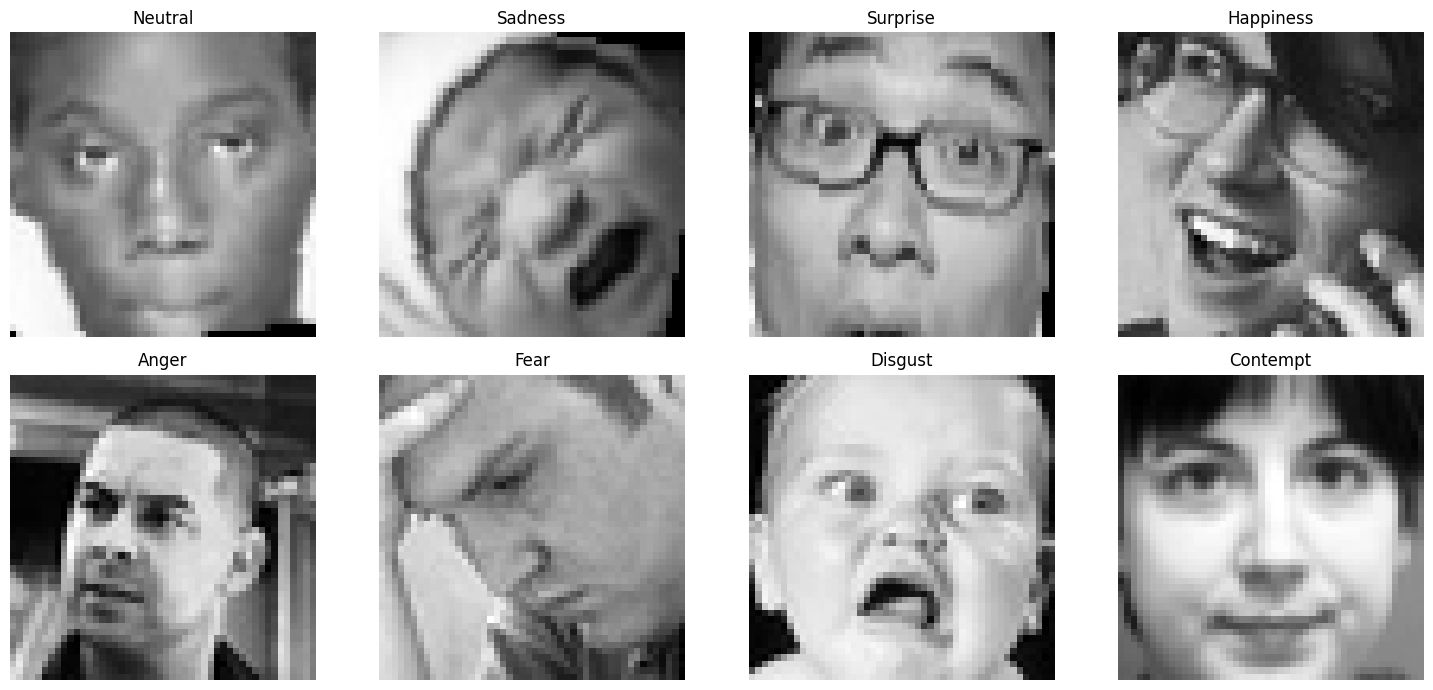

In [7]:
# Visualize a few samples to ensure the data is labelled correctly
with open(dataset_file, 'rb') as f:
    balanced_img_data_dict = pickle.load(f)

fig, axs = plt.subplots(2, 4, figsize=(15, 7))
for i, label in enumerate(balanced_img_data_dict.keys()):
    img_data = balanced_img_data_dict[label]
    img_idx = random.randint(0, len(img_data) - 1)
    img = img_data[img_idx]
    ax = axs[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

It looks like the data has been uploaded correctly.

## Split the data

First of all we want to map the each label (string) into a corrresponding integer in a dictionary. Then we want to combine images and corresponding labels in separate lists and convert them into numpy arrays.

In [3]:
# Load the balanced dataset
with open('balanced_images_labels.pkl', 'rb') as f:
    balanced_img_data_dict = pickle.load(f)

# Initialize lists to collect all images and labels
all_images = []
all_labels = []

# Iterate through the dictionary to collect data
for label, img_list in balanced_img_data_dict.items():
    all_images.extend(img_list)
    all_labels.extend([label] * len(img_list))

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Add channel dimension to images
all_images = np.expand_dims(all_images, axis=1)

# Print the new shape
print(f'Images shape with channel dimension: {all_images.shape}')

Images shape with channel dimension: (72888, 1, 48, 48)


We want to sort the labels with a specific order (e.g., alphabetically), so each time we run the cell, we get the set of labels in the same order.

In [4]:
# List of all unique labels sorted alphabetically
sorted_labels = sorted(set(all_labels))

# Encode labels as integers based on sorted order
label_to_int = {label: idx for idx, label in enumerate(sorted_labels)}
all_labels_int = np.array([label_to_int[label] for label in all_labels])

# Print the encoded labels
print("Label encoding:")
for label, idx in label_to_int.items():
    print(f'{label}: {idx}')


Label encoding:
Anger: 0
Contempt: 1
Disgust: 2
Fear: 3
Happiness: 4
Neutral: 5
Sadness: 6
Surprise: 7


In [5]:
# Create the reverse mapping
int_to_label = {idx: label for label, idx in label_to_int.items()}

# Save the label mapping dictionaries for later use
with open('label_mapping.pkl', 'wb') as f:
    pickle.dump({'label_to_int': label_to_int, 'int_to_label': int_to_label}, f)
print('label_mapping.pkl has been saved')

label_mapping.pkl has been saved


In [6]:
# Convert to PyTorch tensors
all_images_tensor = torch.tensor(all_images, dtype=torch.float32)
all_labels_tensor = torch.tensor(all_labels_int, dtype=torch.int64)

# Combine into a dataset
dataset = TensorDataset(all_images_tensor, all_labels_tensor)

Now we want to split the dataset into train (used to train the model), validation (used to finetune the weights within the training), and test (used to evaluate the model at the end) datasets. Whereas the training and valdiation datasets will be iteratively used during the training process, the test set is separated (to avoid data leakage), and is used to test the effectiveness of the model on new data (once the full training has been completed).

In [7]:
# Calculate lengths for train, validation, and test sets
train_size = int(0.70 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Set seed for reproducibility
torch.manual_seed(42)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print out the sizes of the resulting datasets
print(f'Training data size: {len(train_dataset)}')
print(f'Validation data size: {len(val_dataset)}')
print(f'Test data size: {len(test_dataset)}')

Training data size: 51021
Validation data size: 10933
Test data size: 10934


As a final step we want to create dataloaders, which are utilities responsible of loading the data into the model in batches. We also want to save each dataset into a pickle file, so we can easily load them without having to run the code above each time we open this notebook.

In [8]:
# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Verify the shapes
for images, labels in train_loader:
    print(f'Batch images shape: {images.shape}')
    print(f'Batch labels shape: {labels.shape}')
    break

Batch images shape: torch.Size([32, 1, 48, 48])
Batch labels shape: torch.Size([32])


In [10]:
# Save the datasets
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)
print('train_dataset.pkl has been saved')

with open('val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)
print('val_dataset.pkl has been saved')

with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)
print('test_dataset.pkl has been saved')

train_dataset.pkl has been saved
val_dataset.pkl has been saved
test_dataset.pkl has been saved


In [6]:
# Load the data from a pickle file
train_dataset = pd.read_pickle('train_dataset.pkl')
val_dataset = pd.read_pickle('val_dataset.pkl')
test_dataset = pd.read_pickle('test_dataset.pkl')
label_mapping = pd.read_pickle('label_mapping.pkl')

## Build the models

Even if the images are small, we want to be avle to capture details and microexpressions, so we are adding 4 convolutional layers to the model. This number can be empirically adjusted. Too many convolutional layers will lead to overfitting, while too few convolutional layers will lead to underfitting.

We want to make a deep learning model and add a few hidden layers to capture more complex relationships and patterns. Precisely, whereas convolutional layers focus on feature extraction by applying convolution operations on input data, hidden layers focus on transforming and learning representations from these extracted features. 

#### Model 10

In [50]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)
        self.dropout8 = nn.Dropout(p=0.5)
        self.dropout9 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)
        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        x = F.relu(self.fc5(x))
        x = self.dropout8(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [51]:
model_10 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_10.to(device)

# Summarize the model
summary(model_10, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 11

In [48]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.1)
        self.dropout3 = nn.Dropout(p=0.1)
        self.dropout4 = nn.Dropout(p=0.1)
        self.dropout5 = nn.Dropout(p=0.1)
        self.dropout6 = nn.Dropout(p=0.1)
        self.dropout7 = nn.Dropout(p=0.1)
        self.dropout8 = nn.Dropout(p=0.1)
        self.dropout9 = nn.Dropout(p=0.1)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)
        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        x = F.relu(self.fc5(x))
        x = self.dropout8(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [49]:
model_11 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_11.to(device)

# Summarize the model
summary(model_11, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 12

Let's add batch normalization before each convolutional layer, to ease up the training process.

In [47]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)

        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)
        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)

        return x

In [36]:
model_12 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_12.to(device)

# Summarize the model
summary(model_12, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 13

In [39]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)
        self.dropout8 = nn.Dropout(p=0.5)
        self.dropout9 = nn.Dropout(p=0.5)
        self.dropout10 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [40]:
model_13 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_13.to(device)

# Summarize the model
summary(model_13, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 14

In [21]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)
        self.dropout8 = nn.Dropout(p=0.5)
        self.dropout9 = nn.Dropout(p=0.5)
        self.dropout10 = nn.Dropout(p=0.5)
        self.dropout11 = nn.Dropout(p=0.5)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x


In [22]:
model_14 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_14.to(device)

# Summarize the model
summary(model_14, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 15

In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [24]:
model_15 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_15.to(device)

# Summarize the model
summary(model_15, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 16

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [4]:
model_16 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_16.to(device)

# Summarize the model
summary(model_16, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

### Define Variation of model_16

#### Model 17

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [15]:
model_17 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_17.to(device)

# Summarize the model
summary(model_17, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 18

In [16]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [17]:
model_18 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_18.to(device)

# Summarize the model
summary(model_18, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 19

In [9]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [10]:
model_19 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_19.to(device)

# Summarize the model
summary(model_19, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 20

In [20]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [11]:
model_20 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_20.to(device)

# Summarize the model
summary(model_20, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 21

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [4]:
model_21 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_21.to(device)

# Summarize the model
summary(model_21, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 22

In [41]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [42]:
model_22 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_22.to(device)

# Summarize the model
summary(model_22, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 23

In [17]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [18]:
model_23 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_23.to(device)

# Summarize the model
summary(model_23, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 24

In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [24]:
model_24 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_24.to(device)

# Summarize the model
summary(model_24, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 25

In [38]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [39]:
model_25 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_25.to(device)

# Summarize the model
summary(model_25, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

In [49]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [50]:
model_26 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_26.to(device)

# Summarize the model
summary(model_26, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 27

We are taking the same structure of the model above and decrease the droprout rate from 0.25 to 0.10, to help the model converge.

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.1)
        self.dropout3 = nn.Dropout(p=0.1)
        self.dropout4 = nn.Dropout(p=0.1)
        self.dropout5 = nn.Dropout(p=0.1)
        self.dropout6 = nn.Dropout(p=0.1)
        self.dropout7 = nn.Dropout(p=0.1)
        self.dropout8 = nn.Dropout(p=0.1)
        self.dropout9 = nn.Dropout(p=0.1)
        self.dropout10 = nn.Dropout(p=0.1)
        self.dropout11 = nn.Dropout(p=0.1)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [4]:
model_27 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_27.to(device)

# Summarize the model
summary(model_27, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 28

In [36]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.1)
        self.dropout3 = nn.Dropout(p=0.1)
        self.dropout4 = nn.Dropout(p=0.1)
        self.dropout5 = nn.Dropout(p=0.1)
        self.dropout6 = nn.Dropout(p=0.1)
        self.dropout7 = nn.Dropout(p=0.1)
        self.dropout8 = nn.Dropout(p=0.1)
        self.dropout9 = nn.Dropout(p=0.1)
        self.dropout10 = nn.Dropout(p=0.1)
        self.dropout11 = nn.Dropout(p=0.1)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [37]:
model_28 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_28.to(device)

# Summarize the model
summary(model_28, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 29

We are taking our best performing model (Model 26) to replace relu with elu.

These are the main differences between elu and relu:
- ELU has an extra alpha constant which should be a positive number1.
- ELU allows negative values, pushing mean unit activations closer to zero2.
- ReLU is simpler and computationally less expensive2.

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.elu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.elu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.elu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.elu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.elu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.elu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.elu(self.fc1(x))
        x = self.dropout7(x)
        x = F.elu(self.fc2(x))
        x = self.dropout8(x)
        x = F.elu(self.fc3(x))
        x = self.dropout9(x)
        x = F.elu(self.fc4(x))
        x = self.dropout10(x)
        x = F.elu(self.fc5(x))
        x = self.dropout11(x)
        x = F.elu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [6]:
model_29 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_29.to(device)

# Summarize the model
summary(model_29, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 30

Let's try we some radically different model compared to what we have done so far. Not only we are building a different architecture, but we are also using elu instead of relu as the activation function between layers.

These are the main differences between elu and relu:
- ELU has an extra alpha constant which should be a positive number1.
- ELU allows negative values, pushing mean unit activations closer to zero2.
- ReLU is simpler and computationally less expensive2.

In [2]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.out = nn.Linear(128, 8)  # Change the number of output channels to 8
        
    def forward(self, x):
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.elu(self.bn5(self.conv5(x)))
        x = F.elu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.elu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.out(x)
        
        return x
    


In [3]:
model_30 = CNNModel()
# Saying DCNN and CNN is the same. This is just to sematincally indicate that we are talking about a deep convolutional neural network.
# We will stick with CNN for consistency, and the models are still being considered as DCNNs.

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_30.to(device)

# Summarize the model
summary(model_30, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 48, 48]             640
       BatchNorm2d-2            [1, 64, 48, 48]             128
            Conv2d-3            [1, 64, 48, 48]          36,928
       BatchNorm2d-4            [1, 64, 48, 48]             128
         MaxPool2d-5            [1, 64, 24, 24]               0
           Dropout-6            [1, 64, 24, 24]               0
            Conv2d-7           [1, 128, 24, 24]          73,856
       BatchNorm2d-8           [1, 128, 24, 24]             256
            Conv2d-9           [1, 128, 24, 24]         147,584
      BatchNorm2d-10           [1, 128, 24, 24]             256
        MaxPool2d-11           [1, 128, 12, 12]               0
          Dropout-12           [1, 128, 12, 12]               0
           Conv2d-13           [1, 256, 12, 12]         295,168
      BatchNorm2d-14           [1,

#### Model 31

In [27]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.out = nn.Linear(128, 8)  # Change the number of output channels to 8
        
    def forward(self, x):
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.elu(self.bn5(self.conv5(x)))
        x = F.elu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.elu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.out(x)
        
        return x

In [28]:
model_31 = CNNModel()
# Saying DCNN and CNN is the same. This is just to sematincally indicate that we are talking about a deep convolutional neural network.
# We will stick with CNN for consistency, and the models are still being considered as DCNNs.

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_31.to(device)

# Summarize the model
summary(model_31, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 48, 48]             640
       BatchNorm2d-2            [1, 64, 48, 48]             128
            Conv2d-3            [1, 64, 48, 48]          36,928
       BatchNorm2d-4            [1, 64, 48, 48]             128
         MaxPool2d-5            [1, 64, 24, 24]               0
           Dropout-6            [1, 64, 24, 24]               0
            Conv2d-7           [1, 128, 24, 24]          73,856
       BatchNorm2d-8           [1, 128, 24, 24]             256
            Conv2d-9           [1, 128, 24, 24]         147,584
      BatchNorm2d-10           [1, 128, 24, 24]             256
        MaxPool2d-11           [1, 128, 12, 12]               0
          Dropout-12           [1, 128, 12, 12]               0
           Conv2d-13           [1, 256, 12, 12]         295,168
      BatchNorm2d-14           [1,

#### Model 32

Since relu did slightly better than elu in the other models, we shall try using relu in Model 31 too. Below you can find Model 32, which is Model 31 with relu.

In [2]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.out = nn.Linear(128, 8)  # Change the number of output channels to 8
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.out(x)
        
        return x

In [3]:
model_32 = CNNModel()
# Saying DCNN and CNN is the same. This is just to sematincally indicate that we are talking about a deep convolutional neural network.
# We will stick with CNN for consistency, and the models are still being considered as DCNNs.

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_32.to(device)

# Summarize the model
summary(model_32, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 48, 48]             640
       BatchNorm2d-2            [1, 64, 48, 48]             128
            Conv2d-3            [1, 64, 48, 48]          36,928
       BatchNorm2d-4            [1, 64, 48, 48]             128
         MaxPool2d-5            [1, 64, 24, 24]               0
           Dropout-6            [1, 64, 24, 24]               0
            Conv2d-7           [1, 128, 24, 24]          73,856
       BatchNorm2d-8           [1, 128, 24, 24]             256
            Conv2d-9           [1, 128, 24, 24]         147,584
      BatchNorm2d-10           [1, 128, 24, 24]             256
        MaxPool2d-11           [1, 128, 12, 12]               0
          Dropout-12           [1, 128, 12, 12]               0
           Conv2d-13           [1, 256, 12, 12]         295,168
      BatchNorm2d-14           [1,

#### Model 33

In [19]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.out = nn.Linear(128, 8)  # Change the number of output channels to 8
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.out(x)
        
        return x

In [20]:
model_33 = CNNModel()
# Saying DCNN and CNN is the same. This is just to sematincally indicate that we are talking about a deep convolutional neural network.
# We will stick with CNN for consistency, and the models are still being considered as DCNNs.

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_33.to(device)

# Summarize the model
summary(model_33, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 48, 48]             640
       BatchNorm2d-2            [1, 64, 48, 48]             128
            Conv2d-3            [1, 64, 48, 48]          36,928
       BatchNorm2d-4            [1, 64, 48, 48]             128
         MaxPool2d-5            [1, 64, 24, 24]               0
           Dropout-6            [1, 64, 24, 24]               0
            Conv2d-7           [1, 128, 24, 24]          73,856
       BatchNorm2d-8           [1, 128, 24, 24]             256
            Conv2d-9           [1, 128, 24, 24]         147,584
      BatchNorm2d-10           [1, 128, 24, 24]             256
        MaxPool2d-11           [1, 128, 12, 12]               0
          Dropout-12           [1, 128, 12, 12]               0
           Conv2d-13           [1, 256, 12, 12]         295,168
      BatchNorm2d-14           [1,

## Train and test the models

### Define the hyperparameters

In [4]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_2 = lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)
optimizer_3 = lambda params: optim.Adam(params, lr=0.0005, betas=(0.9, 0.999), weight_decay=1e-5)
optimizer_4 = lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer_5 = lambda params: optim.Adam(params, lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-3)
# We are implementing stricted regularization, and increasing the learning rate at the same time, to not block the model from converging.
optimizer_6 = lambda params: optim.Adam(params, lr=0.01, betas=(0.9, 0.999), weight_decay=1e-2)
# Let's create an optimizer with a higher momentum to avoid the model getting stuck in a local minima
optimizer_7 = lambda params: optim.Adam(params, lr=0.001, betas=(0.95, 0.999), weight_decay=1e-5)
# Let's experiment with higher beta 1, higher weight decay, and higher both
optimizer_8 = lambda params: optim.Adam(params, lr=0.001, betas=(0.99, 0.999), weight_decay=1e-5)
optimizer_9 = lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer_10 = lambda params: optim.Adam(params, lr=0.001, betas=(0.95, 0.999), weight_decay=1e-4)
optimizer_11 = lambda params: optim.Adam(params, lr=0.001, betas=(0.999, 0.999), weight_decay=1e-3)
optimizer_12 = lambda params: optim.Adam(params, lr=0.001, betas=(0.999, 0.999), weight_decay=1e-2)
optimizer_13 = lambda params: optim.Adam(params, lr=0.002, betas=(0.999, 0.999), weight_decay=1e-3)
optimizer_14 = lambda params: optim.Adam(params, lr=0.005, betas=(0.999, 0.999), weight_decay=1e-3)
optimizer_15 = lambda params: optim.Adam(params, lr=0.002, betas=(0.999, 0.999), weight_decay=0.0005)

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
checkpoint_interval = 25  # Save model weights every 5 epochs

# Set number of epochs
num_epochs = 100

In case you opened the book and loaded the data train, test, and validation data from a picke file without going over the first part of the notebook, define the dataloaders here.

In [7]:
# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Helper functions for training, testing, and plotting

In [8]:
#Train the model
def train_model(model, model_name, criterion, optimizer, train_loader,
                val_loader, device, num_epochs, patience,
                checkpoint_interval):
    """
    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - model_name (str): The name to use for saving the model and accuracies.
    - criterion (torch.nn.modules.loss._Loss): The loss function used for training.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - device (torch.device): Device (cpu or cuda) on which to perform computations.
    - num_epochs (int): Number of epochs to train the model.
    - patience (int): Number of epochs to wait for improvement in validation accuracy before stopping early.
    - checkpoint_interval (int): Interval (in epochs) at which to save model checkpoints.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    - val_accuracies (list): List of validation accuracies for each epoch.
    """
    model = model.to(device)
    model.train()  # Set the model to training mode

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_accuracy = 100 * correct / total
        train_accuracies.append(epoch_train_accuracy)
        train_losses.append(running_loss / len(train_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]}, Accuracy: {epoch_train_accuracy}%')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_accuracy = 100 * correct / total
        val_accuracies.append(epoch_val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f'Validation Loss: {val_losses[-1]}, Accuracy: {epoch_val_accuracy}%')

        # Check for early stopping
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch + 1}. Best validation accuracy: {best_val_accuracy}%')
            model.load_state_dict(best_model_wts)
            break

        # Save model checkpoint every checkpoint_interval epochs
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_filename = f'{model_name}_checkpoint_epoch_{epoch + 1}.pth'
            torch.save(model.state_dict(), checkpoint_filename)
            print(f'Checkpoint saved at epoch {epoch + 1}')

    # Load the best model weights before early stopping
    model.load_state_dict(best_model_wts)

    # Save the best model weights
    model_filename = f'{model_name}_best_model.pth'
    torch.save(model.state_dict(), model_filename)
    print(f'Best model saved as {model_filename}')

    # Save the accuracies and model name
    with open(f'{model_name}_accuracies.pkl', 'wb') as f:
        pickle.dump((model_name, train_accuracies, val_accuracies), f)

    return train_losses, train_accuracies, val_losses, val_accuracies



In [9]:
#Test the model
def evaluate_model(model, criterion, test_loader, device, model_name):
    """
    Args:
    - model (torch.nn.Module): The trained neural network model.
    - criterion (torch.nn.modules.loss._Loss): The loss function used for training.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - device (torch.device): Device (cpu or cuda) on which to perform computations.
    - model_name (str): The name or identifier of the model.

    Returns:
    - test_loss (float): Average loss on the test set.
    - test_accuracy (float): Accuracy on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            test_loss += loss.item()  # Accumulate test loss

            _, predicted = torch.max(outputs.data, 1)  # Get predictions
            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels).sum().item()  # Count correct predictions

    test_accuracy = 100 * correct / total

    # Save the test results in a pickle file
    test_results = {
        'test_loss': test_loss / len(test_loader),
        'test_accuracy': test_accuracy
    }
    output_pickle_file = f'{model_name}_test_results.pkl'
    with open(output_pickle_file, 'wb') as f:
        pickle.dump(test_results, f)

    return test_loss / len(test_loader), test_accuracy

In [10]:
# Plot the model performance after training
def plot_training_progress(training_results):
  
    """
    Plot training and validation accuracies across epochs for multiple models.

    Args:
    - training_results (list of tuples): List of tuples containing model names and their respective training and validation accuracies.
      Each tuple should be in the form: (model_name, train_accuracies, val_accuracies).
    """
    plt.figure(figsize=(10, 5))
    
    # Plot training and validation accuracies
    for result in training_results:
        model_name, train_accuracies, val_accuracies = result
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, train_accuracies, label=f'Training Accuracy - {model_name}')
        plt.plot(epochs, val_accuracies, label=f'Validation Accuracy - {model_name}')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [11]:
#Plot the results after testing
def plot_training_validation_test(train_accuracies, val_accuracies, test_accuracy, model_names):
    """
    Plot training, validation, and test accuracy across epochs for multiple models.

    Args:
    - train_accuracies (list of lists): List of lists of training accuracies for each epoch for each model.
    - val_accuracies (list of lists): List of lists of validation accuracies for each epoch for each model.
    - test_accuracy (list): List of accuracies on the test set for each model.
    - model_names (list of str): List of model names corresponding to each set of accuracies.
    """
    plt.figure(figsize=(10, 5))

    # Plot training accuracies
    for i in range(len(train_accuracies)):
        plt.plot(range(1, len(train_accuracies[i]) + 1), train_accuracies[i], label=f'Training Accuracy - {model_names[i]}')

    # Plot validation accuracies
    for i in range(len(val_accuracies)):
        plt.plot(range(1, len(val_accuracies[i]) + 1), val_accuracies[i], label=f'Validation Accuracy - {model_names[i]}')

    # Plot test accuracies
    for i in range(len(test_accuracy)):
        plt.axhline(y=test_accuracy[i], color='r', linestyle='--', label=f'Test Accuracy - {model_names[i]}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation, and Test Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()


### Train the models

We have tried with patience =15 and 20, but even if models do better on the validation set, they do worse on the test set. Therefore, we shall lower the patience parameter so the model stops soon after reaching the inflection point (see on the graph) and plateus.

We can see that adding weight decay and betas to the model improve the performance only slightly. A fine tuting of these two hyperparameters could lead to significant improvements. Another action that can lead to significant improvements, is adding layers to the model, such as hidden layers, to capture more complex relationships in the data; and this is what we are going to do next with model_2.

The model did better earlier, and now it may be underfitting the data. The hidden layers might be to many for the amount of data. Before reducing the hidden layers, let's try to reduce the amount of dropout to 0.10.

#### Train model_10

For model_10 we are going to experoment with a learning rate of 0.0005 since this medium had previously the problem of overshooting the minima.

In [52]:
train_model(model=model_10, model_name="Model_10", criterion=criterion, optimizer=optimizer_3(model_10.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=5, checkpoint_interval=checkpoint_interval)

Epoch [1/100], Loss: 2.0135536174415423, Accuracy: 18.055310558397522%
Validation Loss: 1.8854232367716337, Accuracy: 25.089179548156956%
Epoch [2/100], Loss: 1.6460878727204373, Accuracy: 33.23337449285588%
Validation Loss: 1.510635102701466, Accuracy: 38.48897832250983%
Epoch [3/100], Loss: 1.40522527829233, Accuracy: 43.923090492150294%
Validation Loss: 1.326933642751292, Accuracy: 48.04719656087076%
Epoch [4/100], Loss: 1.1977034415197223, Accuracy: 53.08010427079046%
Validation Loss: 1.1670323460422762, Accuracy: 54.69678953626635%
Epoch [5/100], Loss: 1.0491820501309577, Accuracy: 58.777758178005136%
Validation Loss: 1.1027147276708258, Accuracy: 57.23040336595628%
Epoch [6/100], Loss: 0.9339924482716289, Accuracy: 63.270026067697614%
Validation Loss: 1.0280568779211992, Accuracy: 60.06585566633129%
Epoch [7/100], Loss: 0.8358813397749838, Accuracy: 67.24485995962446%
Validation Loss: 1.044979199505689, Accuracy: 60.84331839385347%
Epoch [8/100], Loss: 0.7452485565668363, Accurac

([2.0135536174415423,
  1.6460878727204373,
  1.40522527829233,
  1.1977034415197223,
  1.0491820501309577,
  0.9339924482716289,
  0.8358813397749838,
  0.7452485565668363,
  0.6485483029232504,
  0.5555111769972176,
  0.46968229747491197,
  0.39945599393317693,
  0.33573010323283065,
  0.2813044408365477,
  0.24337380833947173,
  0.21352268684316766,
  0.1865404636672111,
  0.16304723979703803,
  0.1459980239278599,
  0.1328893630631081,
  0.11598742499124247,
  0.11557349486985947,
  0.10149397445663073,
  0.096996016602753,
  0.08850914730663414,
  0.08658673773464225,
  0.0810466104810021,
  0.0757688673007299,
  0.07301064700426148,
  0.06902696096639771],
 [18.055310558397522,
  33.23337449285588,
  43.923090492150294,
  53.08010427079046,
  58.777758178005136,
  63.270026067697614,
  67.24485995962446,
  70.86885792124811,
  75.23960722055624,
  79.07724270398464,
  82.63656141588757,
  85.48048842633426,
  87.96573959742067,
  90.12367456537504,
  91.48585876403834,
  92.67948

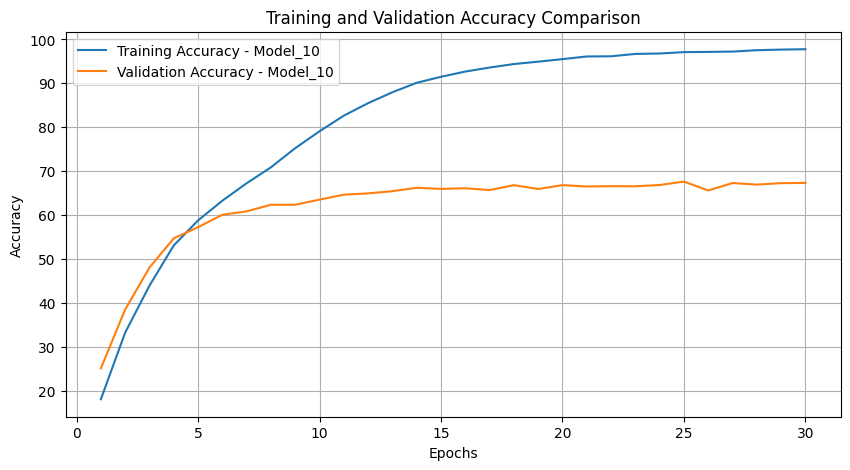

In [53]:
model_name ="Model_10"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_11

In [54]:
train_model(model=model_11, model_name="Model_11", criterion=criterion, optimizer=optimizer_2(model_11.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=num_epochs, patience=patience, checkpoint_interval=checkpoint_interval)

Epoch [1/100], Loss: 1.774068534635825, Accuracy: 29.623096372082085%
Validation Loss: 1.5806351391195554, Accuracy: 38.39751211927193%
Epoch [2/100], Loss: 1.3603650210419418, Accuracy: 46.7219380255189%
Validation Loss: 1.2984012023747316, Accuracy: 48.48623433641269%
Epoch [3/100], Loss: 1.174417488888887, Accuracy: 53.860175221967424%
Validation Loss: 1.1468642915201466, Accuracy: 55.36449281990305%
Epoch [4/100], Loss: 1.040921745890734, Accuracy: 59.03647517688795%
Validation Loss: 1.0623001700256303, Accuracy: 58.56580993322967%
Epoch [5/100], Loss: 0.9398130717696067, Accuracy: 63.00346915975775%
Validation Loss: 1.0264986804005696, Accuracy: 60.175615110216775%
Epoch [6/100], Loss: 0.8485369701931096, Accuracy: 66.85678446130025%
Validation Loss: 0.9954771633036652, Accuracy: 62.425683709869205%
Epoch [7/100], Loss: 0.7670182772004118, Accuracy: 70.2965445600831%
Validation Loss: 1.109451606085426, Accuracy: 60.5323333028446%
Epoch [8/100], Loss: 0.68619813550976, Accuracy: 73

([1.774068534635825,
  1.3603650210419418,
  1.174417488888887,
  1.040921745890734,
  0.9398130717696067,
  0.8485369701931096,
  0.7670182772004118,
  0.68619813550976,
  0.6078156501335037,
  0.5239505205688806,
  0.44720133121204225,
  0.38548406131308655,
  0.3240849439440102,
  0.2837351843726392,
  0.24344023913378626,
  0.21661918591415993,
  0.1977863817601275],
 [29.623096372082085,
  46.7219380255189,
  53.860175221967424,
  59.03647517688795,
  63.00346915975775,
  66.85678446130025,
  70.2965445600831,
  73.79510397679387,
  77.13686521236353,
  80.5648654475608,
  83.79294800180318,
  86.31543874091061,
  88.71445091236941,
  90.17855392877442,
  91.63089708159386,
  92.66772505438936,
  93.30667764253934],
 [1.5806351391195554,
  1.2984012023747316,
  1.1468642915201466,
  1.0623001700256303,
  1.0264986804005696,
  0.9954771633036652,
  1.109451606085426,
  1.0295306113031175,
  1.0561473597908577,
  1.1035883328196598,
  1.2787706942586174,
  1.17497204392277,
  1.2779

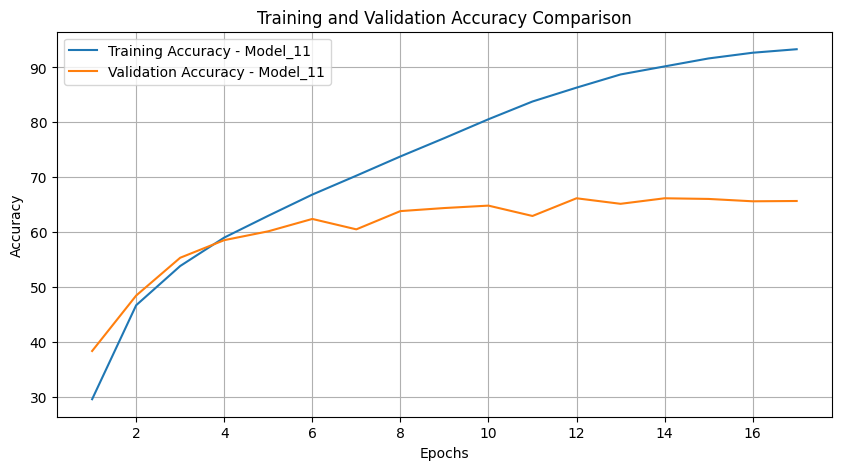

In [55]:
model_name ="Model_11"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_12

It looks like incrementing weight decay made things worse for what concern the test set, so let's try going back to the original weight decay.

In [56]:
train_model(model=model_12, model_name="Model_12_O2", criterion=criterion, optimizer=optimizer_2(model_12.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.790697785380492, Accuracy: 28.464749808902216%
Validation Loss: 1.5087995999737789, Accuracy: 42.714716912100975%
Epoch [2/200], Loss: 1.3661945251461853, Accuracy: 46.308382822759256%
Validation Loss: 1.3047314070121587, Accuracy: 48.312448550260676%
Epoch [3/200], Loss: 1.172665974451083, Accuracy: 53.66613747280532%
Validation Loss: 1.1607591804356603, Accuracy: 54.69678953626635%
Epoch [4/200], Loss: 1.0428352544673931, Accuracy: 58.90907665471081%
Validation Loss: 1.086569508439616, Accuracy: 58.446903869020396%
Epoch [5/200], Loss: 0.9359049108147995, Accuracy: 63.17202720448443%
Validation Loss: 1.0728112546324033, Accuracy: 59.31583279978048%
Epoch [6/200], Loss: 0.8394630231453707, Accuracy: 67.15274102820408%
Validation Loss: 1.017746388040788, Accuracy: 62.84642824476356%
Epoch [7/200], Loss: 0.750469998076418, Accuracy: 70.87081789851237%
Validation Loss: 1.0203911976681814, Accuracy: 63.64218421293332%
Epoch [8/200], Loss: 0.6668837296551672, Accurac

([1.790697785380492,
  1.3661945251461853,
  1.172665974451083,
  1.0428352544673931,
  0.9359049108147995,
  0.8394630231453707,
  0.750469998076418,
  0.6668837296551672,
  0.5789160641476652,
  0.49828314835842125,
  0.4274591548362496,
  0.3607532452523335,
  0.3152312429989674,
  0.27055894576573636,
  0.2431370509403019,
  0.210211089795286,
  0.18512520403615826,
  0.1680160682432377,
  0.16229976939889937,
  0.14050394920281903,
  0.12814508711227265,
  0.11920517064984246,
  0.12054612769666463,
  0.11094747715130401,
  0.11519181548156499,
  0.0984055140895804,
  0.0999793510963968,
  0.10045613083717644,
  0.08914326991868383,
  0.0868930311573211,
  0.08586036218884971,
  0.080643019888026,
  0.08220562627874782,
  0.0807034524082466,
  0.07980129582001638,
  0.07799889242900046,
  0.07188444395455988,
  0.07427245205860193,
  0.06556253435013912,
  0.07020749556527292,
  0.06797287928325133,
  0.0662233583609972,
  0.0641715713931017,
  0.062381386177137725,
  0.0603618593

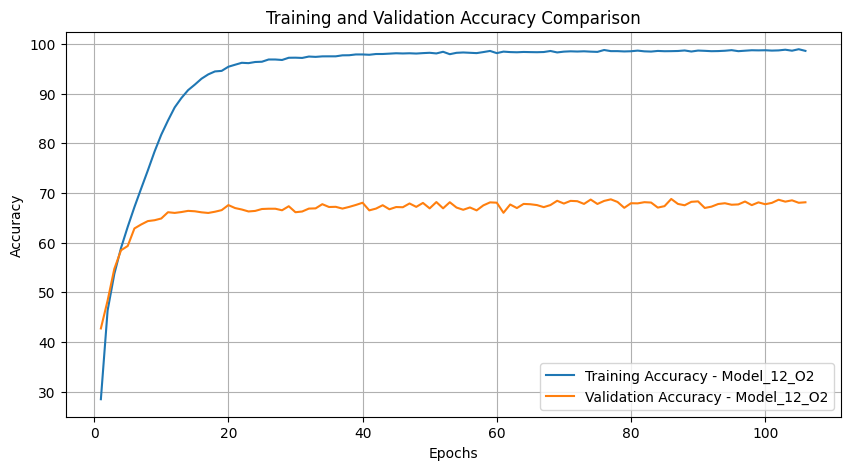

In [57]:
model_name ="Model_12_O2"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_13

In [58]:
train_model(model=model_13, model_name="Model_13", criterion=criterion, optimizer=optimizer_2(model_13.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.9620360664439425, Accuracy: 20.172086003802356%
Validation Loss: 1.8450761071422643, Accuracy: 27.403274490075916%
Epoch [2/200], Loss: 1.5527331801791175, Accuracy: 38.405754493247876%
Validation Loss: 1.3960755205990976, Accuracy: 44.00439037775542%
Epoch [3/200], Loss: 1.2894084144161786, Accuracy: 49.65210403559319%
Validation Loss: 1.237058659394582, Accuracy: 53.05039787798408%
Epoch [4/200], Loss: 1.1203602766915923, Accuracy: 56.69234236882852%
Validation Loss: 1.120697739877199, Accuracy: 57.00173785786152%
Epoch [5/200], Loss: 0.9928292747948985, Accuracy: 60.976852668509046%
Validation Loss: 1.0482102690035837, Accuracy: 59.663404372084514%
Epoch [6/200], Loss: 0.8953851134052098, Accuracy: 64.96148644675722%
Validation Loss: 1.003947485260099, Accuracy: 61.282356169395406%
Epoch [7/200], Loss: 0.8062566505517332, Accuracy: 68.71092295329375%
Validation Loss: 0.9924054869957137, Accuracy: 62.65434921796396%
Epoch [8/200], Loss: 0.7255185475170052, Accu

([1.9620360664439425,
  1.5527331801791175,
  1.2894084144161786,
  1.1203602766915923,
  0.9928292747948985,
  0.8953851134052098,
  0.8062566505517332,
  0.7255185475170052,
  0.6353213461121795,
  0.5515067423959511,
  0.47424207708585225,
  0.40235108153479976,
  0.332136114098155,
  0.28417377308665026,
  0.2420505343816684,
  0.21119758876852202,
  0.19896460375500416,
  0.1696546591070939,
  0.15663444159368525,
  0.14091335850881653,
  0.13845832152525692,
  0.11915789803017082,
  0.11325159744771203,
  0.11145319345700598,
  0.09866751411814406,
  0.10646365109216539,
  0.0976683119124168,
  0.09282572965650764,
  0.08913400593452042,
  0.08690219421487456,
  0.08044681739902158,
  0.08680429728774698,
  0.07260729789031016,
  0.07567028321736699,
  0.07227011158937212,
  0.07001836760437442,
  0.07585507224840886,
  0.06428109556150062,
  0.07297867387233939,
  0.0661786638996761,
  0.067296187605141,
  0.06358271307903221,
  0.06592244157988394,
  0.05933529848603643,
  0.06

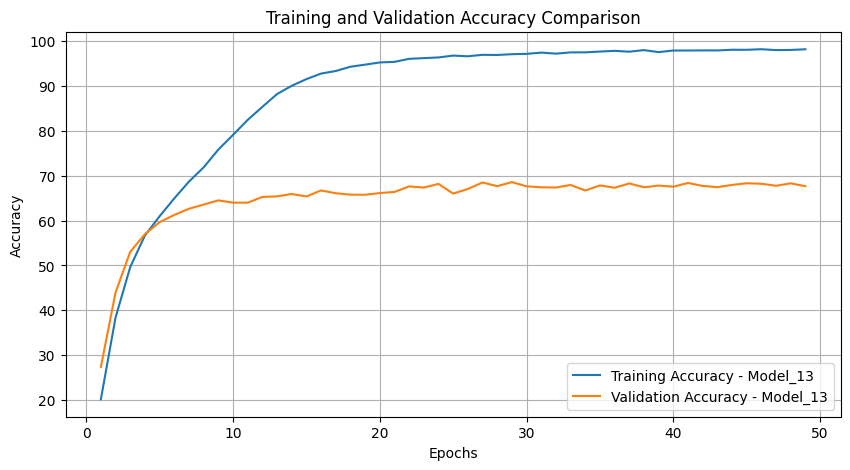

In [59]:
model_name ="Model_13"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_14

In [60]:
train_model(model=model_14, model_name="Model_14", criterion=criterion, optimizer=optimizer_2(model_14.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.9497393201511108, Accuracy: 20.711079751474884%
Validation Loss: 1.839733422499651, Accuracy: 25.125766029452116%
Epoch [2/200], Loss: 1.6357939481735229, Accuracy: 33.321573469747754%
Validation Loss: 1.4953413403522202, Accuracy: 37.68407573401628%
Epoch [3/200], Loss: 1.4177171096532697, Accuracy: 42.32766899903961%
Validation Loss: 1.336045739943521, Accuracy: 45.12027805725784%
Epoch [4/200], Loss: 1.2566669782127333, Accuracy: 50.424335077713096%
Validation Loss: 1.206203152736028, Accuracy: 52.47416079758529%
Epoch [5/200], Loss: 1.1027845254886113, Accuracy: 56.53358421042316%
Validation Loss: 1.127672722639396, Accuracy: 55.8858501783591%
Epoch [6/200], Loss: 0.9959032007332506, Accuracy: 60.5358577840497%
Validation Loss: 1.0972471728659512, Accuracy: 57.14808378304217%
Epoch [7/200], Loss: 0.9107249922700063, Accuracy: 63.82861958801278%
Validation Loss: 1.0502492165007786, Accuracy: 59.2975395591329%
Epoch [8/200], Loss: 0.8325967443774113, Accuracy: 

([1.9497393201511108,
  1.6357939481735229,
  1.4177171096532697,
  1.2566669782127333,
  1.1027845254886113,
  0.9959032007332506,
  0.9107249922700063,
  0.8325967443774113,
  0.7539287072550914,
  0.6770295963298565,
  0.5836327810833073,
  0.5091792870651591,
  0.433340826112088,
  0.375180454916528,
  0.3148107323597031,
  0.283987809624231,
  0.2450633753523184,
  0.2231299235225658,
  0.19980133512644185,
  0.18755803316317757,
  0.16806576472202017,
  0.1589195590571363,
  0.15072049641438692,
  0.13919227732561507,
  0.12852954650035006,
  0.1231804799964377,
  0.12345183662060052,
  0.10406984189462477,
  0.11201180845694646,
  0.10192343512036163,
  0.09566947303626243,
  0.09375087906384613,
  0.08931263984005086,
  0.09059353096156635,
  0.08480212539835866,
  0.09069873161099744,
  0.07367231808650251,
  0.08038858356239671,
  0.0752009872651475,
  0.07950685843964017,
  0.07055901480425546,
  0.07315651084804399,
  0.06388845571032492,
  0.0727958594353798,
  0.066965036

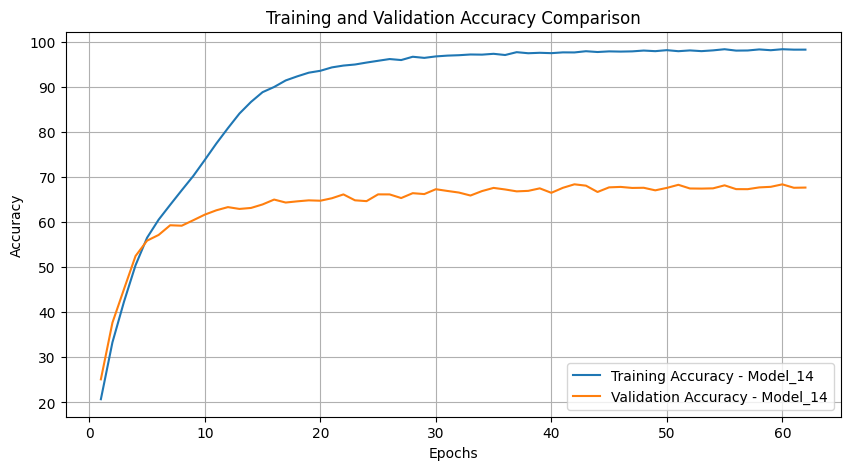

In [61]:
model_name ="Model_14"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_15

In [62]:
train_model(model=model_15, model_name="Model_15", criterion=criterion, optimizer=optimizer_2(model_15.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.8192101595917465, Accuracy: 26.99084690617589%
Validation Loss: 1.6270339935146578, Accuracy: 35.81816518796305%
Epoch [2/200], Loss: 1.5662754846590814, Accuracy: 37.11608945336234%
Validation Loss: 1.4633807567825095, Accuracy: 42.595810847891705%
Epoch [3/200], Loss: 1.3423228374095546, Accuracy: 46.60825934419161%
Validation Loss: 1.2683278221135947, Accuracy: 50.16006585566633%
Epoch [4/200], Loss: 1.182493423855043, Accuracy: 53.203582838439075%
Validation Loss: 1.1735377872896473, Accuracy: 54.66934967529498%
Epoch [5/200], Loss: 1.05977794055281, Accuracy: 57.53709256972619%
Validation Loss: 1.0844345490137737, Accuracy: 57.4956553553462%
Epoch [6/200], Loss: 0.967267368579733, Accuracy: 61.53740616608847%
Validation Loss: 1.1193784851776927, Accuracy: 57.22125674563249%
Epoch [7/200], Loss: 0.8861805612203844, Accuracy: 64.96540640128575%
Validation Loss: 1.0326878513857636, Accuracy: 60.8158785328821%
Epoch [8/200], Loss: 0.7992468272257001, Accuracy: 6

([1.8192101595917465,
  1.5662754846590814,
  1.3423228374095546,
  1.182493423855043,
  1.05977794055281,
  0.967267368579733,
  0.8861805612203844,
  0.7992468272257001,
  0.719992744567626,
  0.6357260724220156,
  0.5621787893361059,
  0.48228479719087247,
  0.40836775681722126,
  0.34959541960476337,
  0.2975733984331819,
  0.25586265640619404,
  0.22788559513219098,
  0.19968835701552864,
  0.1843016404410398,
  0.16625271457711638,
  0.15650640045581707,
  0.13942623236406373,
  0.13433587931849786,
  0.12354612139208376,
  0.1195249283676062,
  0.10877335522963219,
  0.11111837066870568,
  0.095689616883086,
  0.09946972528942584,
  0.09361303994508,
  0.08786942819777517,
  0.08716446645196592,
  0.08614572742362696,
  0.08678671435509928,
  0.08063759885988925,
  0.07430381978154738,
  0.07476366818758445,
  0.07267531052979548,
  0.08474373003828477,
  0.0658050353764549,
  0.06818527968072692,
  0.07204577902402746,
  0.06455034560245297,
  0.06762409703849835,
  0.065293022

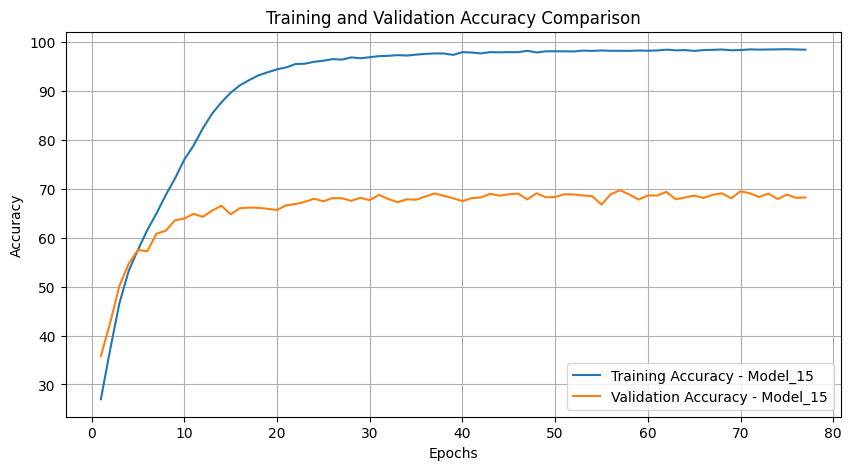

In [63]:
model_name ="Model_15"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_16

In [89]:
train_model(model=model_16, model_name="Model_16", criterion=criterion, optimizer=optimizer_2(model_16.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=10, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.8644714220190497, Accuracy: 23.86860312420376%
Validation Loss: 1.6690817189495466, Accuracy: 31.82109210646666%
Epoch [2/200], Loss: 1.541550207212801, Accuracy: 38.258756198428095%
Validation Loss: 1.3889349500338237, Accuracy: 45.84286106283728%
Epoch [3/200], Loss: 1.3062050823133942, Accuracy: 48.607436153740615%
Validation Loss: 1.250541078242642, Accuracy: 51.093021128692946%
Epoch [4/200], Loss: 1.1682686432401963, Accuracy: 54.05029301660101%
Validation Loss: 1.3700635821847191, Accuracy: 49.08991127778286%
Epoch [5/200], Loss: 1.0593048552734352, Accuracy: 58.21720468042571%
Validation Loss: 1.0946510378380268, Accuracy: 57.14808378304217%
Epoch [6/200], Loss: 0.9539281467098427, Accuracy: 62.65851316124733%
Validation Loss: 1.0759729549550174, Accuracy: 59.45303210463734%
Epoch [7/200], Loss: 0.8670357449488206, Accuracy: 65.9943944650242%
Validation Loss: 1.0920911093204342, Accuracy: 58.98655446812403%
Epoch [8/200], Loss: 0.7714877203714138, Accurac

([1.8644714220190497,
  1.541550207212801,
  1.3062050823133942,
  1.1682686432401963,
  1.0593048552734352,
  0.9539281467098427,
  0.8670357449488206,
  0.7714877203714138,
  0.6888401483293611,
  0.5880216087854021,
  0.49856377798935464,
  0.41184820629959945,
  0.34683319717342015,
  0.2792064762134163,
  0.2384229638990377,
  0.20755549910066642,
  0.18359999342071226,
  0.16678581329494668,
  0.14478957050926633,
  0.1432229284109507,
  0.12679553988760447,
  0.11811995883472264,
  0.1083733664084369,
  0.10752741031211488,
  0.09811186562146303,
  0.09245147009432712,
  0.09267499378749511,
  0.0917282449981478,
  0.09143962546421046,
  0.08391202035889929,
  0.07749661455430137,
  0.08009727608370901,
  0.07569393530494584,
  0.07575345491807248,
  0.07836076619060123,
  0.07522437961518087,
  0.07104088379220518,
  0.0672589003681395,
  0.07142068190043237,
  0.06508719168238847,
  0.07042344007239645,
  0.06508027737692719,
  0.06015085959077162,
  0.062011929979196787,
  0.

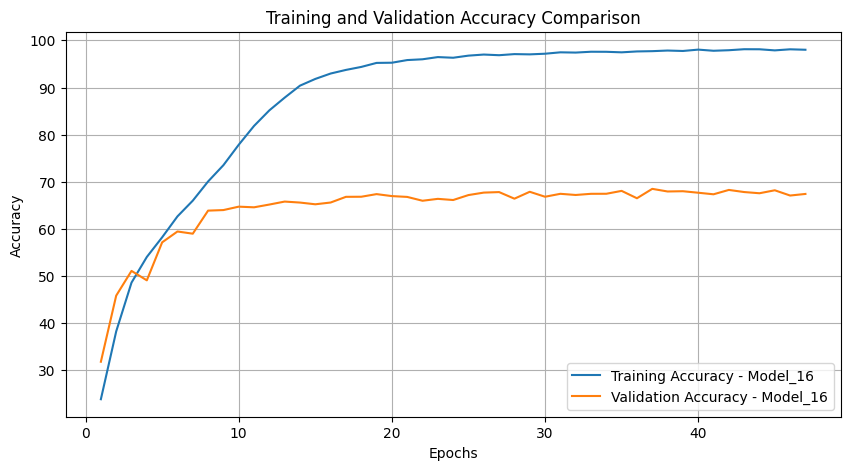

In [90]:
model_name ="Model_16"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train variations of model_16 with the different hyperparapeters on the opimizers

Model 16 looks slightly more stable compared to Model 15, with also slightly less overfitting, slightly lower Test Loss and higher Test Accuracy. This is somehow unexpected, because Model 16 has dropout = 0.1 instead of the 0.25 of Model 15.

Since Model 16 is the best model so far, we are going to experiment with different hyperparameters on the optimizers. In the next example we are invreasing beta 1 to try increasing momentum and avoid the model getting stuck. Indeed, by looking at the charts it looks like the model is getting stuck in a local minima during the validation process.

#### Train model_17 (model 16 - optimizer_7)

In [24]:
train_model(model=model_17, model_name="Model_17", criterion=criterion, optimizer=optimizer_7(model_17.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=10, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.834319845860281, Accuracy: 27.08688579212481%
Validation Loss: 1.6576405460374397, Accuracy: 33.32113783956828%
Epoch [2/200], Loss: 1.5861316726872914, Accuracy: 37.65508320103487%
Validation Loss: 1.4721787554478785, Accuracy: 43.172047928290496%
Epoch [3/200], Loss: 1.3170708616699172, Accuracy: 48.24484035985183%
Validation Loss: 1.2310513962082, Accuracy: 51.065581267721576%
Epoch [4/200], Loss: 1.1513228238563178, Accuracy: 54.446208423982284%
Validation Loss: 1.1321593421941611, Accuracy: 54.587030092380864%
Epoch [5/200], Loss: 1.031384150753948, Accuracy: 59.24031281237138%
Validation Loss: 1.0792922731380017, Accuracy: 57.48650873502241%
Epoch [6/200], Loss: 0.9326051817418639, Accuracy: 62.89175045569471%
Validation Loss: 1.0590396997524283, Accuracy: 58.6298362754962%
Epoch [7/200], Loss: 0.8355435108222932, Accuracy: 66.77642539346543%
Validation Loss: 1.0586425878151118, Accuracy: 59.626817890789354%
Epoch [8/200], Loss: 0.7485521230951746, Accuracy

([1.834319845860281,
  1.5861316726872914,
  1.3170708616699172,
  1.1513228238563178,
  1.031384150753948,
  0.9326051817418639,
  0.8355435108222932,
  0.7485521230951746,
  0.6648596856661351,
  0.5805599526178127,
  0.4924011511582192,
  0.4208442145053496,
  0.3620525399672574,
  0.31194319519269803,
  0.2693367395783573,
  0.24244383219687915,
  0.21338469900109083,
  0.19267077547699493,
  0.178585834316267,
  0.1643859663528615,
  0.14369409490656984,
  0.1414725825415346,
  0.13091649195809957,
  0.12500922434633382,
  0.1196358656348678,
  0.11775256312221616,
  0.10424688638485005,
  0.10544262898269877,
  0.09999548542900098,
  0.09784843055976607,
  0.09184657427683753,
  0.09485892537976892,
  0.08571380228103434,
  0.08768135155813891,
  0.08958323786172397,
  0.07980429377577626,
  0.08550222596401046,
  0.07683030431144973,
  0.07957419372883737,
  0.07634556765520659,
  0.07250856600275196,
  0.07739806360394334,
  0.06699968592473962,
  0.07397452504388684,
  0.06535

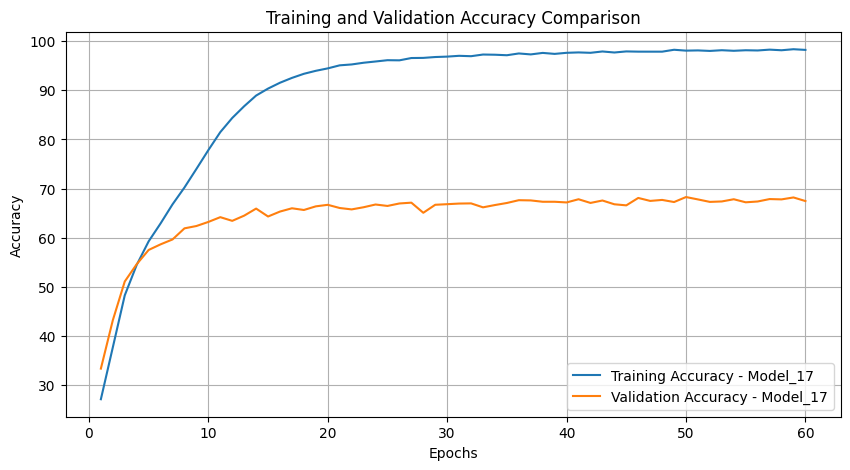

In [25]:
model_name ="Model_17"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_18 (model 16 - optimizer_8)

In [26]:
train_model(model=model_18, model_name="Model_18", criterion=criterion, optimizer=optimizer_8(model_18.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=10, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.854214681353315, Accuracy: 25.854060092902923%
Validation Loss: 1.6572938289558679, Accuracy: 34.02542760450014%
Epoch [2/200], Loss: 1.584790139586948, Accuracy: 36.0753415260383%
Validation Loss: 1.496633179355086, Accuracy: 39.59571938168847%
Epoch [3/200], Loss: 1.423573244253296, Accuracy: 42.77846376982027%
Validation Loss: 1.365418853466971, Accuracy: 44.72697338333486%
Epoch [4/200], Loss: 1.2734221248417439, Accuracy: 49.356147468689365%
Validation Loss: 1.2268626935649336, Accuracy: 50.84606237995061%
Epoch [5/200], Loss: 1.1308467987936492, Accuracy: 54.69708551380804%
Validation Loss: 1.159409318751062, Accuracy: 54.73337601756151%
Epoch [6/200], Loss: 1.0311903817152903, Accuracy: 58.36420297524549%
Validation Loss: 1.142681469519933, Accuracy: 55.49254550443611%
Epoch [7/200], Loss: 0.9628547016356058, Accuracy: 61.62168518845181%
Validation Loss: 1.0858431190078022, Accuracy: 58.10847891704015%
Epoch [8/200], Loss: 0.8682580912748474, Accuracy: 65.

([1.854214681353315,
  1.584790139586948,
  1.423573244253296,
  1.2734221248417439,
  1.1308467987936492,
  1.0311903817152903,
  0.9628547016356058,
  0.8682580912748474,
  0.7969847048151082,
  0.7073266816363439,
  0.6304873039075947,
  0.5550793901132566,
  0.4716784554495707,
  0.3988411273795609,
  0.34039325195957315,
  0.29612580799150245,
  0.25255300329653635,
  0.21859045347029513,
  0.18982878716364737,
  0.1768794692063056,
  0.16350717611208,
  0.15067753659905778,
  0.13343744188296056,
  0.1279058637138351,
  0.1172503211780752,
  0.11293848100188407,
  0.10927569663508278,
  0.10542141713346516,
  0.09720078431804106,
  0.09230209640198063,
  0.09392775295391317,
  0.08276604222795024,
  0.08763174274768447,
  0.08072151174311902,
  0.08518011847286132,
  0.0780416744500603,
  0.07662582469083731,
  0.07211574991503701,
  0.07243033111406356,
  0.07188914897285992,
  0.07230349888650665,
  0.06873352295696461,
  0.06448645668077285,
  0.06812133785011684,
  0.06798250

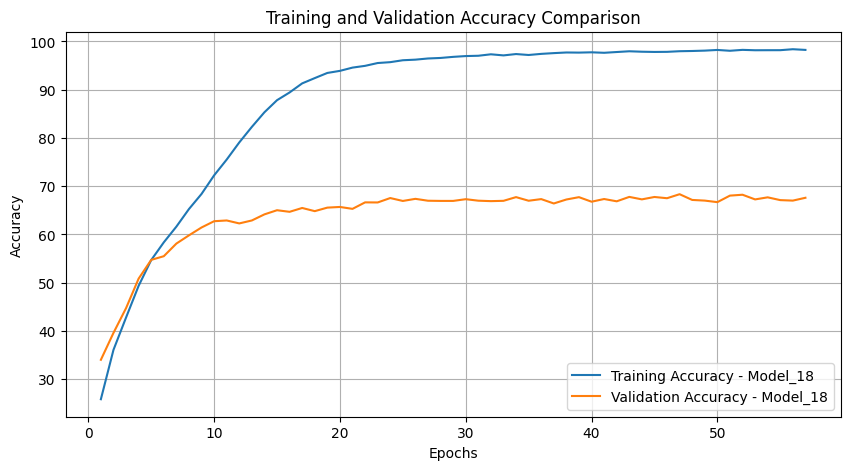

In [27]:
model_name ="Model_18"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_19 (model 16 - optimizer_9)

Looking at the chart, this model has the potential to train further, so let's increase the patience parameter.

In [28]:
train_model(model=model_19, model_name="Model_19", criterion=criterion, optimizer=optimizer_9(model_19.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.8467058344694514, Accuracy: 25.959898865173162%
Validation Loss: 1.7129172940700375, Accuracy: 35.02240921979329%
Epoch [2/200], Loss: 1.5384953644582096, Accuracy: 39.69737951039768%
Validation Loss: 1.3471120681330475, Accuracy: 46.3001920790268%
Epoch [3/200], Loss: 1.2900205345363078, Accuracy: 49.14054996962035%
Validation Loss: 1.3106004468530241, Accuracy: 50.43446446538004%
Epoch [4/200], Loss: 1.1628666950991162, Accuracy: 54.53440740087415%
Validation Loss: 1.128963057409253, Accuracy: 55.77609073447361%
Epoch [5/200], Loss: 1.063649087938769, Accuracy: 58.51316124732953%
Validation Loss: 1.092035186221028, Accuracy: 57.74261410408854%
Epoch [6/200], Loss: 0.977487131943897, Accuracy: 61.747123733364695%
Validation Loss: 1.0792663407604597, Accuracy: 58.96826122747645%
Epoch [7/200], Loss: 0.9094030770762214, Accuracy: 64.25197467709374%
Validation Loss: 1.0138632410276702, Accuracy: 60.8158785328821%
Epoch [8/200], Loss: 0.843526798561449, Accuracy: 67

([1.8467058344694514,
  1.5384953644582096,
  1.2900205345363078,
  1.1628666950991162,
  1.063649087938769,
  0.977487131943897,
  0.9094030770762214,
  0.843526798561449,
  0.777068636054903,
  0.727566929857559,
  0.6648274188318223,
  0.6078141931175812,
  0.5537540550142246,
  0.5027927875892496,
  0.4588889824185626,
  0.4170793685653367,
  0.37373408827241683,
  0.3526867571856161,
  0.3245626930766345,
  0.30635130148042333,
  0.2802810156863872,
  0.2677918623280376,
  0.250710795727503,
  0.24215024170059957,
  0.2293675262370033,
  0.2162422883928663,
  0.2134700424332744,
  0.20304549642631253,
  0.1967981104817837,
  0.18089620224623518,
  0.1816892367469433,
  0.17499447898781598,
  0.17210624851432388,
  0.164541450861059,
  0.16533944875901116,
  0.15961139551787215,
  0.1592961493540894,
  0.1501020223991274,
  0.15319941944404736,
  0.1477606899551697,
  0.14642396497023424,
  0.1483422235118628,
  0.14613339458840394,
  0.143507112742498,
  0.1381488581342757,
  0.14

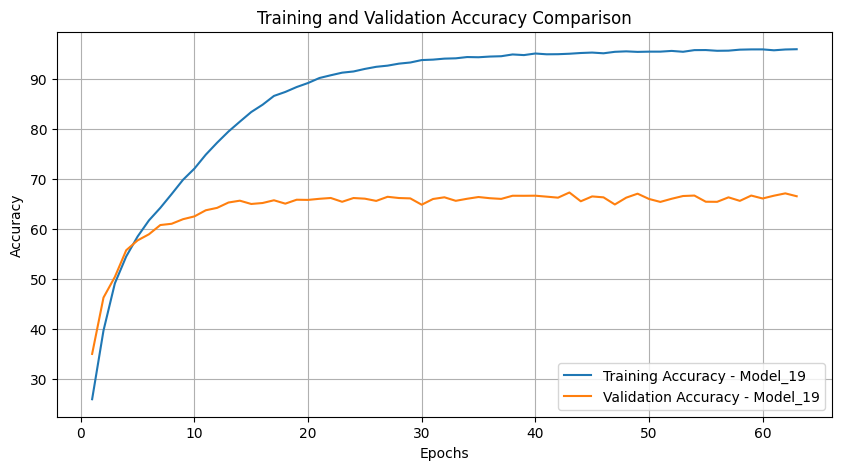

In [29]:
model_name ="Model_19"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_20 (model 16 - optimizer_10)

In [30]:
train_model(model=model_20, model_name="Model_20", criterion=criterion, optimizer=optimizer_10(model_20.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=10, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.915022330000109, Accuracy: 23.36096901275945%
Validation Loss: 1.8936804679402135, Accuracy: 25.18979237171865%
Epoch [2/200], Loss: 1.629898755378484, Accuracy: 35.40306932439584%
Validation Loss: 1.5135353688608135, Accuracy: 40.20854294338242%
Epoch [3/200], Loss: 1.3774446095792476, Accuracy: 46.37306207247996%
Validation Loss: 1.2664000198506473, Accuracy: 49.78505442239093%
Epoch [4/200], Loss: 1.1996811931036109, Accuracy: 53.20162286117481%
Validation Loss: 1.224512525469239, Accuracy: 51.90707033751029%
Epoch [5/200], Loss: 1.1069491350164982, Accuracy: 56.80406107289156%
Validation Loss: 1.1423877519473695, Accuracy: 55.602304948321596%
Epoch [6/200], Loss: 1.0366035586987916, Accuracy: 59.63426824248839%
Validation Loss: 1.1360671365121653, Accuracy: 57.358456050489345%
Epoch [7/200], Loss: 0.9743838569960998, Accuracy: 62.072479959232474%
Validation Loss: 1.0723861746969279, Accuracy: 58.65727613646757%
Epoch [8/200], Loss: 0.9258448969047272, Accurac

([1.915022330000109,
  1.629898755378484,
  1.3774446095792476,
  1.1996811931036109,
  1.1069491350164982,
  1.0366035586987916,
  0.9743838569960998,
  0.9258448969047272,
  0.8648508654679624,
  0.8189702447492128,
  0.7587598943317946,
  0.7046393234901668,
  0.6477652375600929,
  0.5917136012573601,
  0.5410580262681908,
  0.49486245478395385,
  0.45188860345783655,
  0.4172704597298628,
  0.3813329141295068,
  0.35065200391421125,
  0.33139402726927897,
  0.3052671081500367,
  0.2909151727456284,
  0.2673109991020497,
  0.2552630346875673,
  0.2463702710573109,
  0.23015534887586642,
  0.22843774744721135,
  0.2224754787526067,
  0.20670149590306242,
  0.20612487175201175,
  0.19304000522626044,
  0.1941565703524738,
  0.19133455062454396,
  0.18643444717415028,
  0.18001219662064014,
  0.17036434766372263,
  0.17374142123310357,
  0.16938631673369756,
  0.16433167273009366,
  0.1698576525566066,
  0.1589306064878465,
  0.16492555065425024,
  0.15332030827167872,
  0.153738438327

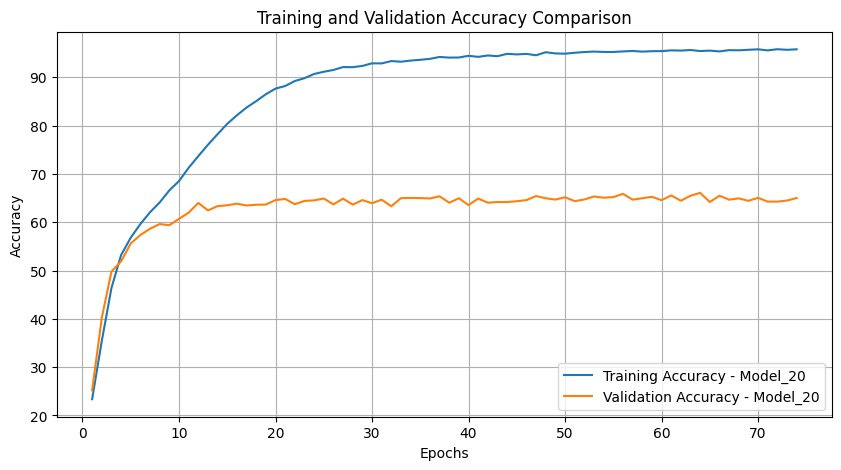

In [31]:
model_name ="Model_20"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_21 (model 16 - optimizer_11)

In [11]:
train_model(model=model_21, model_name="Model_21", criterion=criterion, optimizer=optimizer_11(model_21.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.9720058425466842, Accuracy: 19.782050528213873%
Validation Loss: 1.7744809563396966, Accuracy: 29.378944480014635%
Epoch [2/200], Loss: 1.6821574455518333, Accuracy: 32.58266204112032%
Validation Loss: 1.5793551858405621, Accuracy: 37.043812311350955%
Epoch [3/200], Loss: 1.5597214711497196, Accuracy: 37.280727543560495%
Validation Loss: 1.5270127441450867, Accuracy: 37.65663587304491%
Epoch [4/200], Loss: 1.4800250783983069, Accuracy: 40.78712686932832%
Validation Loss: 1.5058686841301054, Accuracy: 41.32443062288485%
Epoch [5/200], Loss: 1.4171303345865591, Accuracy: 44.10144842319829%
Validation Loss: 1.4206440488845982, Accuracy: 44.26049574682155%
Epoch [6/200], Loss: 1.349260352659375, Accuracy: 46.98065502440172%
Validation Loss: 1.3526799384264918, Accuracy: 46.3916582822647%
Epoch [7/200], Loss: 1.2527071985705145, Accuracy: 50.294976578271694%
Validation Loss: 1.2595274922443411, Accuracy: 50.20579895728528%
Epoch [8/200], Loss: 1.1798502680649952, Accu

([1.9720058425466842,
  1.6821574455518333,
  1.5597214711497196,
  1.4800250783983069,
  1.4171303345865591,
  1.349260352659375,
  1.2527071985705145,
  1.1798502680649952,
  1.1364400906996293,
  1.0815062021387034,
  1.0601508476891115,
  1.0314564953216565,
  1.0129989246589637,
  0.9929388769741716,
  0.9754181840389874,
  0.9576306048979206,
  0.9408053100295949,
  0.9286633820556174,
  0.931480878180471,
  0.9046869698549886,
  0.9027916047640355,
  0.8914202943490964,
  0.8745044432089994,
  0.8656471963212782,
  0.8593742711977526,
  0.8478676653207282,
  0.8350623315591423,
  0.8402312176541475,
  0.8130665762203988,
  0.8156063525467457,
  0.8110897866909781,
  0.8063727872125034,
  0.7920428421803777,
  0.7821606761609499,
  0.7732933997080244,
  0.7682600739607617,
  0.7428631082504147,
  0.7519758497099144,
  0.7743064873270854,
  0.761568582637183,
  0.7342471174311862,
  0.7455309399616755,
  0.7214310859998565,
  0.7155507225414802,
  0.7139025369501413,
  0.712565707

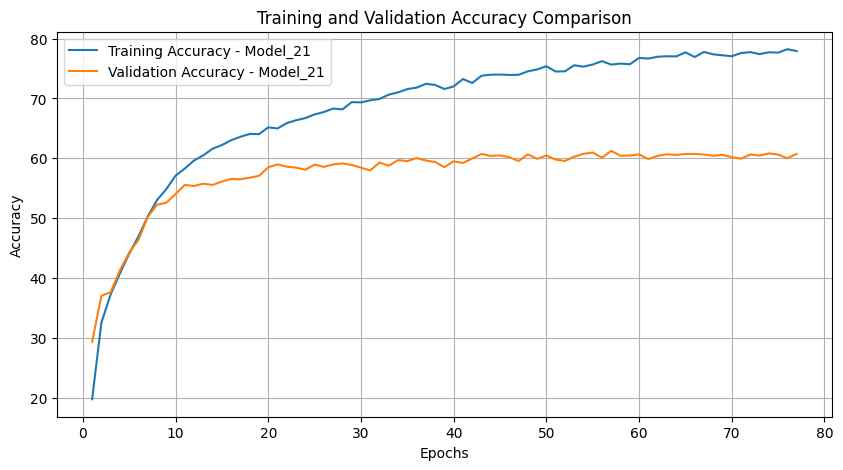

In [12]:
model_name ="Model_21"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_22 (model 16 - optimizer_12)

In [46]:
train_model(model=model_22, model_name="Model_22", criterion=criterion, optimizer=optimizer_12(model_22.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=10, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 2.080282876932509, Accuracy: 12.367456537504165%
Validation Loss: 2.0794831137908134, Accuracy: 12.604042806183115%
Epoch [2/200], Loss: 2.0795540492736433, Accuracy: 12.392936241939594%
Validation Loss: 2.079484600072716, Accuracy: 12.229031372907711%
Epoch [3/200], Loss: 2.07954902977779, Accuracy: 12.434095764489133%
Validation Loss: 2.0795776300262987, Accuracy: 12.119271929022226%
Epoch [4/200], Loss: 2.079585259536217, Accuracy: 12.498775014209835%
Validation Loss: 2.0795397493574352, Accuracy: 12.658922528125858%
Epoch [5/200], Loss: 2.0795370341094683, Accuracy: 12.520334764116736%
Validation Loss: 2.079520933809336, Accuracy: 12.658922528125858%
Epoch [6/200], Loss: 2.0794808921395425, Accuracy: 12.602653809215813%
Validation Loss: 2.079598895987572, Accuracy: 12.119271929022226%
Epoch [7/200], Loss: 2.07949002499117, Accuracy: 12.518374786852473%
Validation Loss: 2.079490861697504, Accuracy: 12.293057715174243%
Epoch [8/200], Loss: 2.079523755913618, Accu

([2.080282876932509,
  2.0795540492736433,
  2.07954902977779,
  2.079585259536217,
  2.0795370341094683,
  2.0794808921395425,
  2.07949002499117,
  2.079523755913618,
  2.079502150855468,
  2.0795527938017653,
  2.0794822573288108,
  2.0794894873161676,
  2.0795471580050955,
  2.0795119780358102],
 [12.367456537504165,
  12.392936241939594,
  12.434095764489133,
  12.498775014209835,
  12.520334764116736,
  12.602653809215813,
  12.518374786852473,
  12.42233590090355,
  12.45369553713177,
  12.189098606456165,
  12.586973991101702,
  12.447815605338977,
  12.398816173732385,
  12.263577742498187],
 [2.0794831137908134,
  2.079484600072716,
  2.0795776300262987,
  2.0795397493574352,
  2.079520933809336,
  2.079598895987572,
  2.079490861697504,
  2.0795527808150354,
  2.079537820397762,
  2.079434333488955,
  2.0795562030279147,
  2.079462402745297,
  2.0795513238126073,
  2.0794280474646047],
 [12.604042806183115,
  12.229031372907711,
  12.119271929022226,
  12.658922528125858,
  

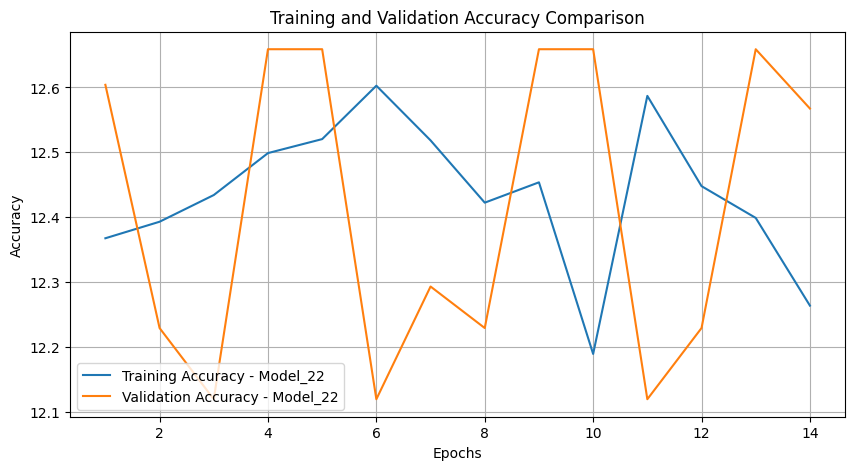

In [47]:
model_name ="Model_22"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

In this model, a weight decay of 0.01 is to high and the model fails to converge. Also beta 1 is 0.999, which is the maxium, and this might have made the model overshooting the global minima.

#### Train model_23

Model 21 gave some interesting results, and it had the lowest overfitting between the models, due to the higher weight decay. However, the model is very slow to train. So we are training it again but increasing the learning rate.

In [19]:
train_model(model=model_23, model_name="Model_23", criterion=criterion, optimizer=optimizer_13(model_23.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.9745676286541929, Accuracy: 20.691479978832245%
Validation Loss: 1.7694249916494937, Accuracy: 28.51001554925455%
Epoch [2/200], Loss: 1.6767623095676816, Accuracy: 32.54150251857079%
Validation Loss: 1.6459462823923567, Accuracy: 33.696149272843684%
Epoch [3/200], Loss: 1.5697763369001192, Accuracy: 36.44381725171988%
Validation Loss: 1.5329802541704902, Accuracy: 39.10180188420379%
Epoch [4/200], Loss: 1.4959391789002852, Accuracy: 40.04037553164383%
Validation Loss: 1.4967723649147657, Accuracy: 40.77563340345742%
Epoch [5/200], Loss: 1.4451066720822014, Accuracy: 42.25318986299759%
Validation Loss: 1.4322103061522657, Accuracy: 44.09585658099332%
Epoch [6/200], Loss: 1.416547195851616, Accuracy: 43.92113051488603%
Validation Loss: 1.4539793848294265, Accuracy: 43.144608067319126%
Epoch [7/200], Loss: 1.3972867317707935, Accuracy: 45.373473667705454%
Validation Loss: 1.4138439189620882, Accuracy: 45.367236806000186%
Epoch [8/200], Loss: 1.3977339114141314, Acc

([1.9745676286541929,
  1.6767623095676816,
  1.5697763369001192,
  1.4959391789002852,
  1.4451066720822014,
  1.416547195851616,
  1.3972867317707935,
  1.3977339114141314,
  1.3839740098830675,
  1.3257575976437537,
  1.2881236065144075,
  1.2297909314729576,
  1.20601650203657,
  1.182318610008981,
  1.1600094184980123,
  1.1420761284783343,
  1.1274272810329091,
  1.1198818680074147,
  1.1061391995244638,
  1.0785679940893358,
  1.0666366216157297,
  1.0516046702674937,
  1.0435752665734963,
  1.0311771089380437,
  1.014055266967014,
  1.005111476022248,
  0.9994580659373054,
  0.9894786857138607,
  0.9881667949749758,
  0.9838905895017905,
  0.9743786753531908,
  0.9650220928520992,
  0.9700419259295568,
  0.960078563996617,
  0.9687534556306642,
  0.9631054475576526,
  0.9408903258908131,
  0.9467593792650767,
  0.9520935306728446,
  0.937683874555516,
  0.9273027169480219,
  0.9430542635319749,
  0.9291603626502345,
  0.9166327512936906,
  0.9270923738756149,
  0.92011534351166

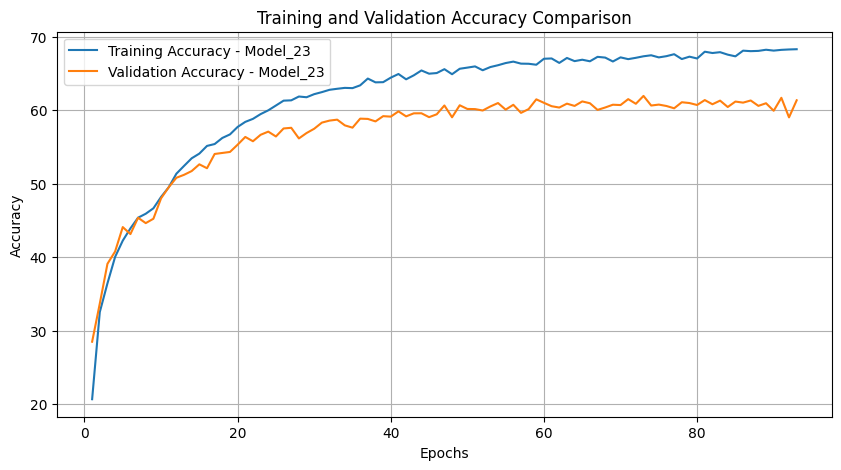

In [20]:
model_name ="Model_23"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_24

It looks like that increasing weight decay and learning rate gave us very interesting results, reducing overfitting drastically. However, the model fails to converge completly. So we can run some other tests by increasing learning rate and decrease weight decay.

In [48]:
optimizer_14 = lambda params: optim.Adam(params, lr=0.005, betas=(0.999, 0.999), weight_decay=1e-3)

In [26]:
train_model(model=model_24, model_name="Model_24", criterion=criterion, optimizer=optimizer_14(model_24.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.9060193043891165, Accuracy: 23.16105133180455%
Validation Loss: 1.7349828338762472, Accuracy: 29.97347480106101%
Epoch [2/200], Loss: 1.6898642837440705, Accuracy: 32.20830638364595%
Validation Loss: 1.6022363413147063, Accuracy: 35.56205981889692%
Epoch [3/200], Loss: 1.5566734606195767, Accuracy: 38.3508751298485%
Validation Loss: 1.5003883859567475, Accuracy: 41.86408122198848%
Epoch [4/200], Loss: 1.488745869401854, Accuracy: 42.072871954685326%
Validation Loss: 1.4581380416775307, Accuracy: 43.62937894448002%
Epoch [5/200], Loss: 1.461248819768242, Accuracy: 43.79569196997315%
Validation Loss: 1.4554846373914976, Accuracy: 43.784871489984454%
Epoch [6/200], Loss: 1.4517618365796008, Accuracy: 44.4738441034084%
Validation Loss: 1.4303146241701137, Accuracy: 45.78798134089454%
Epoch [7/200], Loss: 1.445984930678221, Accuracy: 44.90307912428216%
Validation Loss: 1.4780044517321893, Accuracy: 43.47388639897558%
Epoch [8/200], Loss: 1.4374535917114688, Accuracy: 

([1.9060193043891165,
  1.6898642837440705,
  1.5566734606195767,
  1.488745869401854,
  1.461248819768242,
  1.4517618365796008,
  1.445984930678221,
  1.4374535917114688,
  1.3601578747964578,
  1.3097414018965814,
  1.2730171798164942,
  1.2434468206940774,
  1.2411256032303957,
  1.2292175189828425,
  1.2074990372299026,
  1.21660035915883,
  1.2158758965031855,
  1.198846592200587,
  1.2039017000542165,
  1.203786793098928,
  1.1920813979773686,
  1.2018051279002222,
  1.1992180845580505,
  1.194157101741779,
  1.1883904742222968,
  1.1771053834768672,
  1.1868659657744405,
  1.1884627506650727,
  1.178886118017394,
  1.174956898106303,
  1.17637312643954,
  1.1689685570782629,
  1.17724258395198,
  1.1749972278047878,
  1.186041442989182,
  1.1704215949605625,
  1.163285917510807,
  1.160601696699017,
  1.1494539216394335,
  1.1699469961716464,
  1.1542765710421117,
  1.1624808181042208,
  1.1667542665729702,
  1.1603395820411395,
  1.1637728229959183,
  1.1652174710480023,
  1.1

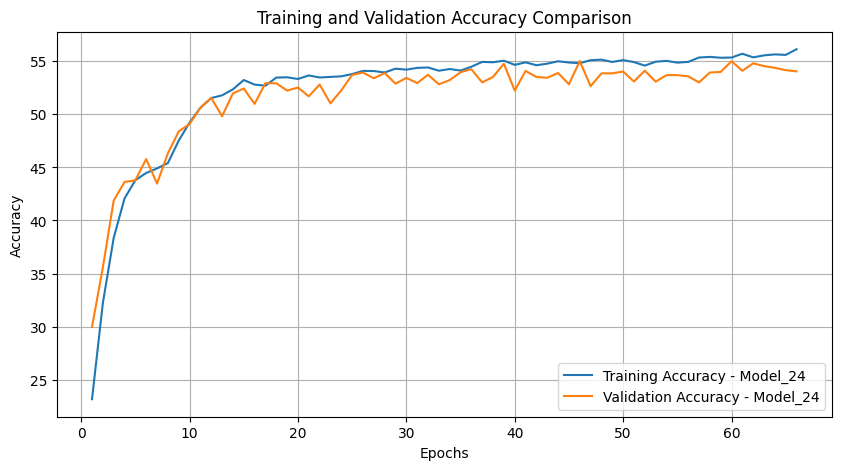

In [27]:
model_name ="Model_24"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_25

In [ ]:
optimizer_15 = lambda params: optim.Adam(params, lr=0.002, betas=(0.999, 0.999), weight_decay=0.0005)

In [45]:
train_model(model=model_25, model_name="Model_25", criterion=criterion, optimizer=optimizer_15(model_25.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.9224244541509024, Accuracy: 21.961545246075147%
Validation Loss: 1.7474171665676854, Accuracy: 25.95810847891704%
Epoch [2/200], Loss: 1.6919768181714145, Accuracy: 31.796711158150565%
Validation Loss: 1.6409823884043777, Accuracy: 33.50407024604409%
Epoch [3/200], Loss: 1.542429010098257, Accuracy: 37.31208717978871%
Validation Loss: 1.4765360724856282, Accuracy: 39.48595993780298%
Epoch [4/200], Loss: 1.4281190087429034, Accuracy: 42.37274847611768%
Validation Loss: 1.3481154203066352, Accuracy: 47.251440592700995%
Epoch [5/200], Loss: 1.288177257010182, Accuracy: 49.16798965132004%
Validation Loss: 1.290951124757354, Accuracy: 49.528949053324794%
Epoch [6/200], Loss: 1.2122577107438472, Accuracy: 51.69832029948453%
Validation Loss: 1.2231746460610664, Accuracy: 51.90707033751029%
Epoch [7/200], Loss: 1.1665276942955662, Accuracy: 53.387820701279864%
Validation Loss: 1.308004778553868, Accuracy: 49.37345650782036%
Epoch [8/200], Loss: 1.1440508383194854, Accura

([1.9224244541509024,
  1.6919768181714145,
  1.542429010098257,
  1.4281190087429034,
  1.288177257010182,
  1.2122577107438472,
  1.1665276942955662,
  1.1440508383194854,
  1.0939012680681521,
  1.0836811548863832,
  1.0551560682749674,
  1.037522683808796,
  1.0369791404954318,
  1.0231627019221505,
  1.0043287035066133,
  0.9988789158555034,
  0.9804032823135113,
  0.9643940572080941,
  0.9628580116179296,
  0.9563398431087362,
  0.9602081897303603,
  0.9516240144598073,
  0.9379164024019689,
  0.9254640780272528,
  0.931532751037783,
  0.9336260655643798,
  0.946208511549851,
  0.9231289614704336,
  0.929353428578302,
  0.9261182740564257,
  0.9222533703971433,
  0.923624037519144,
  0.9244842245287282,
  0.9224235605670367,
  0.9117299589243802,
  0.9071806258168714,
  0.9017244789854486,
  0.9094465540494291,
  0.9031067888564824,
  0.9254845270729364,
  0.9209006245793967,
  0.9158030424745852,
  0.9084006549609492,
  0.8934704015434349,
  0.893477568843148,
  0.90867324609741

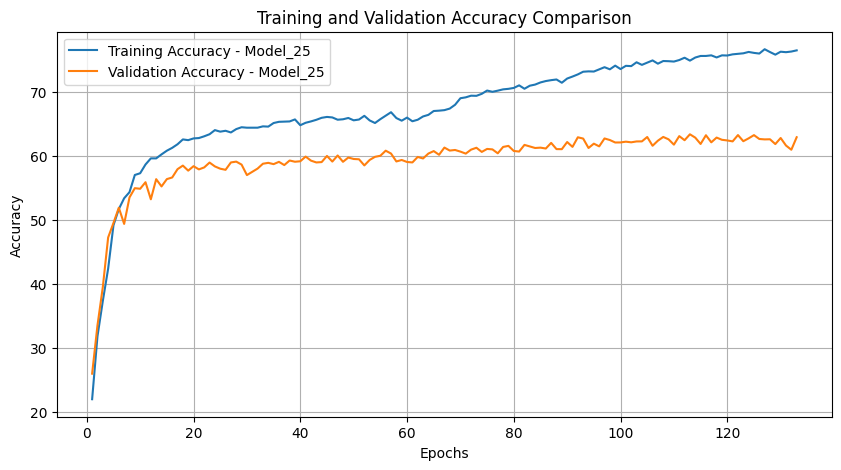

In [46]:
model_name ="Model_25"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_26

In [51]:
optimizer_16 = lambda params: optim.Adam(params, lr=0.003, betas=(0.999, 0.999), weight_decay=0.0003)

In [52]:
train_model(model=model_26, model_name="Model_26", criterion=criterion, optimizer=optimizer_16(model_26.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.9514112439648859, Accuracy: 21.636189020207365%
Validation Loss: 1.7038716436826695, Accuracy: 31.135095582182384%
Epoch [2/200], Loss: 1.6545801631335555, Accuracy: 33.26865408361263%
Validation Loss: 1.5441503061188593, Accuracy: 36.67794749839934%
Epoch [3/200], Loss: 1.5200513318788296, Accuracy: 39.26422453499539%
Validation Loss: 1.5091168061334488, Accuracy: 40.62928747827678%
Epoch [4/200], Loss: 1.4403782655079163, Accuracy: 43.850571333372535%
Validation Loss: 1.4334585583000852, Accuracy: 44.370255190707034%
Epoch [5/200], Loss: 1.50979585412154, Accuracy: 42.08267184100664%
Validation Loss: 1.5597378384997274, Accuracy: 40.272569285648956%
Epoch [6/200], Loss: 1.492800208954228, Accuracy: 42.90978224652594%
Validation Loss: 1.436240725175679, Accuracy: 44.873319308515505%
Epoch [7/200], Loss: 1.3801591912033415, Accuracy: 45.96342682424884%
Validation Loss: 1.342680951133806, Accuracy: 47.06850818622519%
Epoch [8/200], Loss: 1.2829351232343333, Accura

([1.9514112439648859,
  1.6545801631335555,
  1.5200513318788296,
  1.4403782655079163,
  1.50979585412154,
  1.492800208954228,
  1.3801591912033415,
  1.2829351232343333,
  1.2319244339548308,
  1.1960361361877299,
  1.1475773911491083,
  1.1051249542953827,
  1.0773145380064986,
  1.0512764377653785,
  1.0240130336307058,
  1.0150802707223683,
  0.9939821145190715,
  0.9704027974119754,
  0.9541296653613027,
  0.9591139519102521,
  0.9359082877822804,
  0.9310343514415538,
  0.9230099930098065,
  0.9283831417000032,
  0.9240975138161998,
  0.9116308874844757,
  0.9162209662524137,
  0.8997190305058111,
  0.9168305410673626,
  0.9033071449370967,
  0.8898165194778981,
  0.8938058982822215,
  0.8820027449661662,
  0.8776899951565602,
  0.8701625850320236,
  0.8877809895990785,
  0.8716691304523743,
  0.8706841359131015,
  0.8696743262412032,
  0.8498361282774647,
  0.8544461863541678,
  0.8639302118071195,
  0.8467878147539301,
  0.8534237257365522,
  0.8482679109401464,
  0.859269415

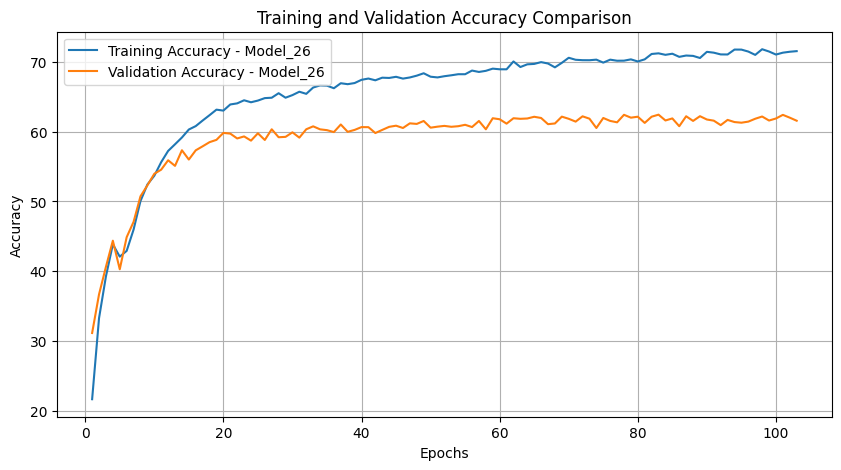

In [53]:
model_name ="Model_26"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_27

In [15]:
optimizer_14 = lambda params: optim.Adam(params, lr=0.005, betas=(0.999, 0.999), weight_decay=1e-3)

In [16]:
train_model(model=model_27, model_name="Model_27", criterion=criterion, optimizer=optimizer_14(model_27.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.9191554310179804, Accuracy: 22.516218811861783%
Validation Loss: 1.7251341684519896, Accuracy: 27.769139303027533%
Epoch [2/200], Loss: 1.6824429522487436, Accuracy: 32.094627702318654%
Validation Loss: 1.5980352239999158, Accuracy: 36.65050763742797%
Epoch [3/200], Loss: 1.5745675167693614, Accuracy: 37.04161031732032%
Validation Loss: 1.5601117283280133, Accuracy: 38.24201957376749%
Epoch [4/200], Loss: 1.5128588723912135, Accuracy: 39.98157621371592%
Validation Loss: 1.5295168112593087, Accuracy: 40.373182109210646%
Epoch [5/200], Loss: 1.4243422745163539, Accuracy: 44.203367240940004%
Validation Loss: 1.4184894387484992, Accuracy: 44.53489435653526%
Epoch [6/200], Loss: 1.3659410931473615, Accuracy: 46.576899707963385%
Validation Loss: 1.37670612195779, Accuracy: 46.31848531967438%
Epoch [7/200], Loss: 1.3364031669114451, Accuracy: 47.61568765802317%
Validation Loss: 1.3600716207459655, Accuracy: 47.02277508460624%
Epoch [8/200], Loss: 1.3323397685741556, Acc

([1.9191554310179804,
  1.6824429522487436,
  1.5745675167693614,
  1.5128588723912135,
  1.4243422745163539,
  1.3659410931473615,
  1.3364031669114451,
  1.3323397685741556,
  1.3164588882257946,
  1.2974558231225208,
  1.25884039999923,
  1.2513648461772358,
  1.237909886904271,
  1.22884858188958,
  1.2232821803107905,
  1.2257901353148457,
  1.211028153507687,
  1.1998243975415126,
  1.1895044459444601,
  1.2007428734653796,
  1.1920070016645712,
  1.1901589516188285,
  1.1903655935604371,
  1.1960701131148024,
  1.1936390012782943,
  1.1848389417026484,
  1.176380760580021,
  1.176715346264615,
  1.1690481582031729,
  1.170067120868958,
  1.1794087825897719,
  1.1739603075861558,
  1.1655031406019922,
  1.1810032497752796,
  1.17034480788491,
  1.169517639625035,
  1.1695172163760026,
  1.1577920438914464,
  1.1730946024757194,
  1.174834215379434,
  1.1633902828147793,
  1.154550831631807,
  1.1707698854906805,
  1.1567393579453136,
  1.1610298356479238,
  1.1771725693092825,
  

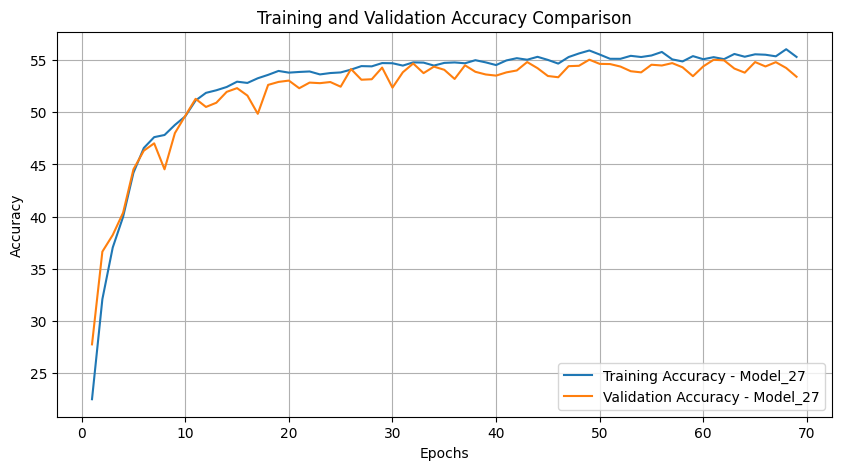

In [17]:
model_name ="Model_27"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_28

In [18]:
optimizer_16 = lambda params: optim.Adam(params, lr=0.003, betas=(0.999, 0.999), weight_decay=0.0003)

In [19]:
train_model(model=model_28, model_name="Model_28", criterion=criterion, optimizer=optimizer_16(model_28.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.9560777556559883, Accuracy: 20.856118069030398%
Validation Loss: 1.7344910282837718, Accuracy: 29.70822281167109%
Epoch [2/200], Loss: 1.6767998497314214, Accuracy: 31.555633954646126%
Validation Loss: 1.722008630546213, Accuracy: 32.406475807189246%
Epoch [3/200], Loss: 1.5970167381262705, Accuracy: 35.58926716450089%
Validation Loss: 1.5686194171682435, Accuracy: 36.6230677764566%
Epoch [4/200], Loss: 1.514557556186724, Accuracy: 38.59587228788146%
Validation Loss: 1.5483165885272778, Accuracy: 38.47068508186225%
Epoch [5/200], Loss: 1.463917343780912, Accuracy: 41.71027616079653%
Validation Loss: 1.4697686740529468, Accuracy: 42.19335955364493%
Epoch [6/200], Loss: 1.43732249015551, Accuracy: 42.81178338331275%
Validation Loss: 1.4442208972242143, Accuracy: 42.73301015274856%
Epoch [7/200], Loss: 1.4039855485425847, Accuracy: 44.54244330765763%
Validation Loss: 1.4122259289200543, Accuracy: 44.68124028171591%
Epoch [8/200], Loss: 1.372352972710768, Accuracy: 4

([1.9560777556559883,
  1.6767998497314214,
  1.5970167381262705,
  1.514557556186724,
  1.463917343780912,
  1.43732249015551,
  1.4039855485425847,
  1.372352972710768,
  1.314144046777468,
  1.2710751096656703,
  1.2331957995331027,
  1.205857428973745,
  1.1723819696043727,
  1.1478593852452723,
  1.1333655100631117,
  1.1232797008696769,
  1.1072953533603107,
  1.090713757967874,
  1.0606356604719611,
  1.0493690341991317,
  1.031380038687428,
  1.0271314093685449,
  1.0224346532343322,
  1.011009624123947,
  1.0105596392879665,
  1.0072081882191302,
  0.9961588447744196,
  0.990059453678729,
  0.9820283313156295,
  0.972055192146929,
  0.9635085902991339,
  0.9457395270700365,
  0.9475728026004421,
  0.9386616556061472,
  0.9369103711600588,
  0.9309896004797896,
  0.914186938448012,
  0.9149231805323059,
  0.9068835810807805,
  0.9129389594154298,
  0.9163002056948444,
  0.9062714341665884,
  0.9101474247008655,
  0.9018889869642108,
  0.8966678812772877,
  0.8978012982020184,
 

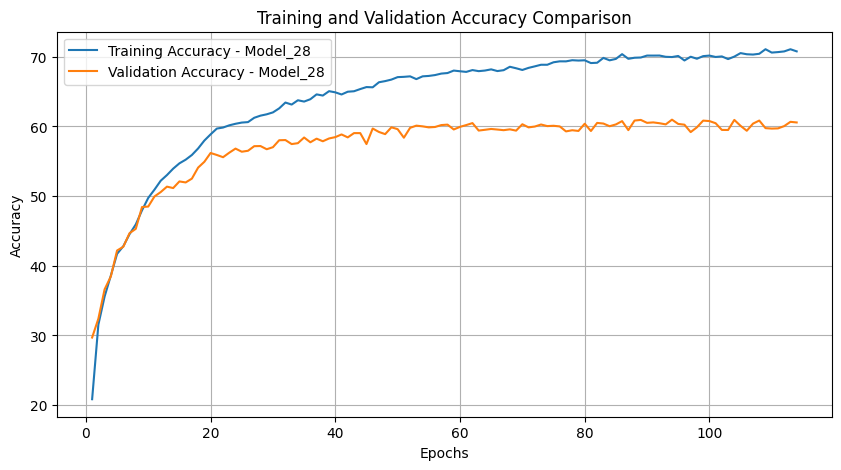

In [20]:
model_name ="Model_28"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_29

In [13]:
optimizer_16 = lambda params: optim.Adam(params, lr=0.003, betas=(0.999, 0.999), weight_decay=0.0003)

In [29]:
train_model(model=model_29, model_name="Model_29", criterion=criterion, optimizer=optimizer_16(model_29.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.7460027600530548, Accuracy: 33.55285078693087%
Validation Loss: 1.5020692758044305, Accuracy: 43.839751211927194%
Epoch [2/200], Loss: 1.4130962414053914, Accuracy: 45.11671664608691%
Validation Loss: 1.3010097708966997, Accuracy: 48.74233970547883%
Epoch [3/200], Loss: 1.2697254201087833, Accuracy: 50.27537680562906%
Validation Loss: 1.2926263558237177, Accuracy: 50.535077288941736%
Epoch [4/200], Loss: 1.191575070757851, Accuracy: 53.15850336136101%
Validation Loss: 1.1860644920179022, Accuracy: 53.306503247050216%
Epoch [5/200], Loss: 1.1297121342446736, Accuracy: 55.361517806393444%
Validation Loss: 1.1641195777215456, Accuracy: 54.80654898015183%
Epoch [6/200], Loss: 1.08797172087487, Accuracy: 56.93929950412575%
Validation Loss: 1.1708426013676048, Accuracy: 55.3096130979603%
Epoch [7/200], Loss: 1.0412519869385841, Accuracy: 58.90907665471081%
Validation Loss: 1.1433814655967622, Accuracy: 55.51083874508369%
Epoch [8/200], Loss: 1.018279048791126, Accuracy

([1.7460027600530548,
  1.4130962414053914,
  1.2697254201087833,
  1.191575070757851,
  1.1297121342446736,
  1.08797172087487,
  1.0412519869385841,
  1.018279048791126,
  0.981507576857241,
  0.960358396406084,
  0.9500752831327504,
  0.9296342779663289,
  0.906211618457842,
  0.8980069900381153,
  0.8718523402946496,
  0.870487750828453,
  0.8729398652864474,
  0.8565376959624336,
  0.8405517997973391,
  0.8348799921315292,
  0.8225971288255016,
  0.8117302759874577,
  0.8144428423579584,
  0.8146668701896846,
  0.8098196498465762,
  0.8218721325494652,
  0.8043263059424756,
  0.8021969136586383,
  0.7820927077139432,
  0.778298666877059,
  0.7704204995243527,
  0.7707643088502196,
  0.7572818194717449,
  0.7666789943708522,
  0.7696172181715413,
  0.7678771684349144,
  0.7561472126122178,
  0.7450945652764419,
  0.7448316997121494,
  0.7523596338156996,
  0.7485442970053156,
  0.7419217311663314,
  0.7467965928177849,
  0.7451997226121657,
  0.7324555944873248,
  0.728325943924416

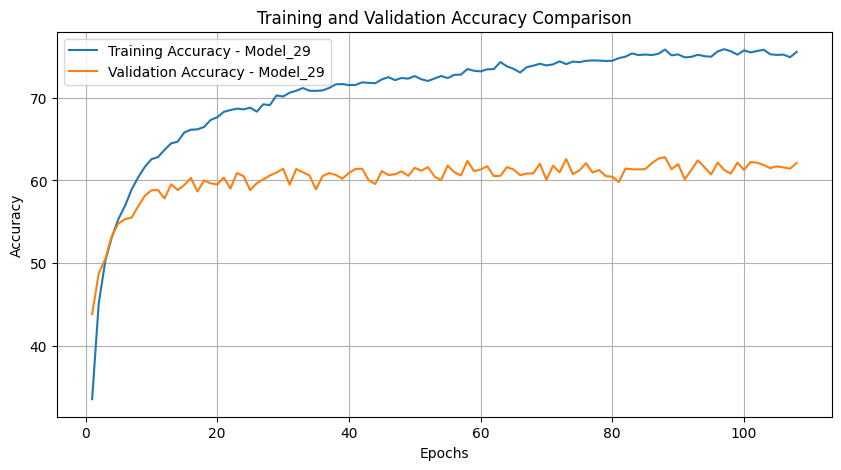

In [30]:
model_name ="Model_29"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_30

In [19]:
optimizer_17 = lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), weight_decay=1e-07)

If these hyperparameters don't work (especially the decay), let's revert back to optimizer_16. The same holds for Adam Vs Nadam optimizers.
Moreover, as specified when defining the model, if this model works well, we are going to try the elu activation function also in models 26 and 24. If it doesn't work well, we are going to apply relu in this model.

In [20]:
train_model(model=model_30, model_name="Model_30", criterion=criterion, optimizer=optimizer_17(model_30.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=10, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.5392016547974374, Accuracy: 42.960741655396795%
Validation Loss: 1.245451110322573, Accuracy: 53.269916765755056%
Epoch [2/200], Loss: 1.123044776318589, Accuracy: 57.51945277434782%
Validation Loss: 1.0408836801846821, Accuracy: 61.10857038324339%
Epoch [3/200], Loss: 0.9142057277378991, Accuracy: 65.34956194508143%
Validation Loss: 0.9114118603586453, Accuracy: 66.04774535809018%
Epoch [4/200], Loss: 0.717250603642957, Accuracy: 72.99935320750279%
Validation Loss: 0.9043935887646257, Accuracy: 66.82520808561236%
Epoch [5/200], Loss: 0.5043358739780782, Accuracy: 81.13521883146156%
Validation Loss: 0.9483959300999056, Accuracy: 68.6911186316656%
Epoch [6/200], Loss: 0.3024727184150286, Accuracy: 88.94572822955254%
Validation Loss: 1.1137167187462076, Accuracy: 69.6515137656636%
Epoch [7/200], Loss: 0.19380651387505723, Accuracy: 93.05776052997786%
Validation Loss: 1.3235396300142968, Accuracy: 69.0752766852648%
Epoch [8/200], Loss: 0.15309423761059848, Accuracy:

([1.5392016547974374,
  1.123044776318589,
  0.9142057277378991,
  0.717250603642957,
  0.5043358739780782,
  0.3024727184150286,
  0.19380651387505723,
  0.15309423761059848,
  0.11888020545679223,
  0.10963891928454972,
  0.09870523257339067,
  0.09019069910957404,
  0.07955078760980917,
  0.08371123117881939,
  0.06504404791756709,
  0.07223003622630558,
  0.06513099464795699,
  0.059177000900339276,
  0.05601958070812235,
  0.052842586864186775,
  0.05405440930030593,
  0.04930153387990044],
 [42.960741655396795,
  57.51945277434782,
  65.34956194508143,
  72.99935320750279,
  81.13521883146156,
  88.94572822955254,
  93.05776052997786,
  94.64730209129574,
  95.90756747221732,
  96.24272358440642,
  96.71703808235824,
  97.00907469473354,
  97.40891005664334,
  97.19723251210286,
  97.86362478195252,
  97.64410732835499,
  97.86362478195252,
  98.12038180357108,
  98.13214166715666,
  98.27913996197644,
  98.26150016659807,
  98.4222183022677],
 [1.245451110322573,
  1.04088368018

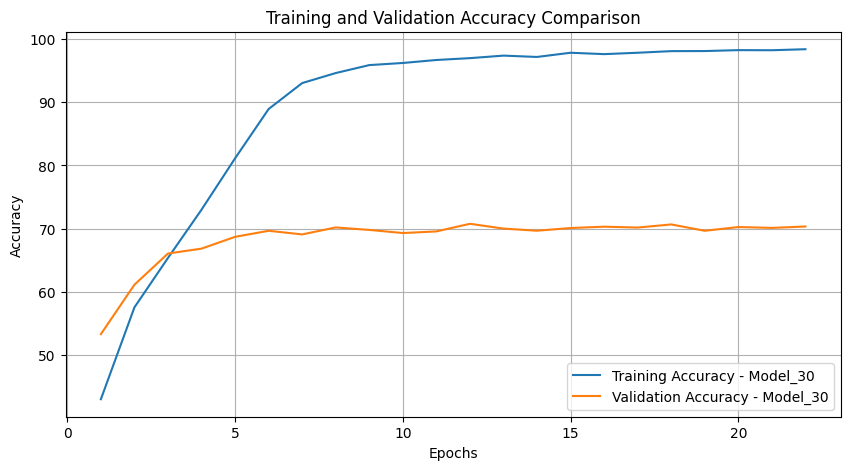

In [21]:
model_name ="Model_30"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_31

In [31]:
optimizer_16 = lambda params: optim.Adam(params, lr=0.003, betas=(0.999, 0.999), weight_decay=0.0003)

In [33]:
train_model(model=model_31, model_name="Model_31", criterion=criterion, optimizer=optimizer_16(model_31.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.786195532730007, Accuracy: 33.072656357186254%
Validation Loss: 1.526715994578356, Accuracy: 42.94338242019574%
Epoch [2/200], Loss: 1.4095098438307783, Accuracy: 46.92381568373807%
Validation Loss: 1.3267666566790195, Accuracy: 49.995426689838105%
Epoch [3/200], Loss: 1.2090897563109204, Accuracy: 54.24629074302738%
Validation Loss: 1.1554411963412636, Accuracy: 56.33403457422482%
Epoch [4/200], Loss: 1.0891991009532844, Accuracy: 58.63467983771388%
Validation Loss: 1.0732989459358462, Accuracy: 59.22436659654258%
Epoch [5/200], Loss: 0.9972853296229085, Accuracy: 62.13323925442465%
Validation Loss: 1.0419480176697, Accuracy: 60.55977316381597%
Epoch [6/200], Loss: 0.9243503916973604, Accuracy: 64.87524744712961%
Validation Loss: 1.0071585359629134, Accuracy: 61.60248788072807%
Epoch [7/200], Loss: 0.8763079862796401, Accuracy: 66.88814409752847%
Validation Loss: 1.007855289686493, Accuracy: 61.959206073355894%
Epoch [8/200], Loss: 0.8383282942084309, Accuracy: 

([1.786195532730007,
  1.4095098438307783,
  1.2090897563109204,
  1.0891991009532844,
  0.9972853296229085,
  0.9243503916973604,
  0.8763079862796401,
  0.8383282942084309,
  0.8033342685071653,
  0.7629586121879027,
  0.7287616630146122,
  0.6987408819803997,
  0.6935529371320641,
  0.6717506392435594,
  0.6394645690637696,
  0.6176857257991749,
  0.6026070693817258,
  0.6012421299951577,
  0.5759924733900351,
  0.5613535328064593,
  0.5505755116199625,
  0.5448528351127915,
  0.5373398802123474,
  0.5221228024802611,
  0.5198820251422616,
  0.5178153777944631,
  0.5074232601073094,
  0.49610035920217865,
  0.488117058766673,
  0.4833480431274934,
  0.4892568995492959,
  0.48370916343594794,
  0.464419093074096,
  0.46493533588595526],
 [33.072656357186254,
  46.92381568373807,
  54.24629074302738,
  58.63467983771388,
  62.13323925442465,
  64.87524744712961,
  66.88814409752847,
  68.0425707061798,
  69.80263028948865,
  71.22949373787264,
  72.60147782285725,
  73.46582779639756,

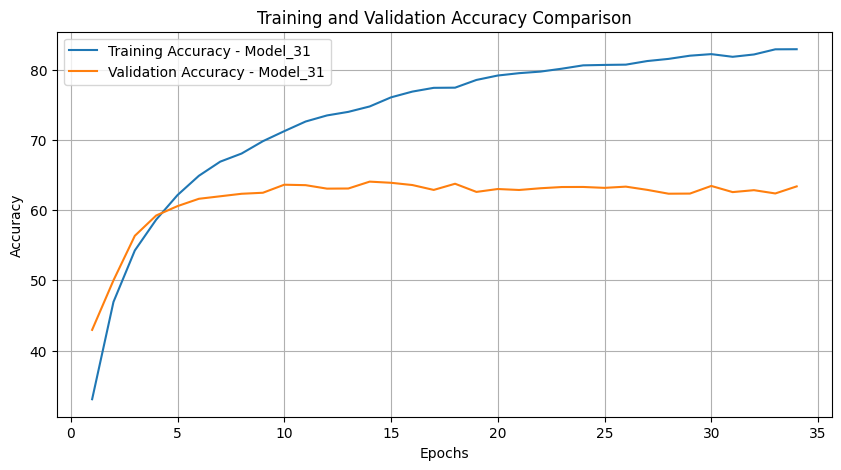

In [34]:
model_name ="Model_31"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_32

We took model_31, swapped elu with relu, and decreased learning rate, beta 1, and increased weight decay to reduce overfitting. Indeed, model_31 did relatively well, but converge quite too fast, and from the curve we can see some signs of overfitting. But the model has also some good potential, and could overtake the more complex Model 26 as the best model.

In [12]:
optimizer_18 = lambda params: optim.Adam(params, lr=0.001, betas=(0.995, 0.999), weight_decay=0.0005)

In [14]:
train_model(model=model_32, model_name="Model_32", criterion=criterion, optimizer=optimizer_18(model_32.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=20, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.6566501854355433, Accuracy: 37.15528899864761%
Validation Loss: 1.314840796223858, Accuracy: 50.69056983444617%
Epoch [2/200], Loss: 1.2101469442388482, Accuracy: 54.20317124321358%
Validation Loss: 1.119916104956677, Accuracy: 57.57797493826031%
Epoch [3/200], Loss: 1.0618796906127452, Accuracy: 59.80282628721507%
Validation Loss: 1.0804341064210523, Accuracy: 58.74874233970548%
Epoch [4/200], Loss: 0.9639442235885369, Accuracy: 63.479743634973836%
Validation Loss: 1.0106043827812574, Accuracy: 62.416537089545415%
Epoch [5/200], Loss: 0.895245177282435, Accuracy: 66.41382959957664%
Validation Loss: 0.9603543128186499, Accuracy: 63.87084972102808%
Epoch [6/200], Loss: 0.8203970168264682, Accuracy: 69.23815683738069%
Validation Loss: 0.9470515831520683, Accuracy: 64.35562059818896%
Epoch [7/200], Loss: 0.7606898550516386, Accuracy: 71.60188941808275%
Validation Loss: 0.9382503667072943, Accuracy: 65.42577517607243%
Epoch [8/200], Loss: 0.7064431140415347, Accuracy

([1.6566501854355433,
  1.2101469442388482,
  1.0618796906127452,
  0.9639442235885369,
  0.895245177282435,
  0.8203970168264682,
  0.7606898550516386,
  0.7064431140415347,
  0.6281705250093556,
  0.5658990451441289,
  0.5056479122991846,
  0.4631192961269785,
  0.4124989157887088,
  0.3834208857723538,
  0.34355038136804367,
  0.3157607320894642,
  0.294351239407838,
  0.28824721093882216,
  0.27629131754293895,
  0.27233961901764697,
  0.25845283424499266,
  0.25141440265487913,
  0.24890797854077107,
  0.22978167243442005,
  0.233460481729954,
  0.23196534633893393,
  0.22984393246320067,
  0.22123280915148485,
  0.2138660745017908,
  0.22052434751863204,
  0.21730042161495894,
  0.21921445039629375,
  0.2098643243429616,
  0.20515831458939934,
  0.20543980700807604],
 [37.15528899864761,
  54.20317124321358,
  59.80282628721507,
  63.479743634973836,
  66.41382959957664,
  69.23815683738069,
  71.60188941808275,
  73.4207483193195,
  76.65275082809039,
  79.09292252209875,
  81.4

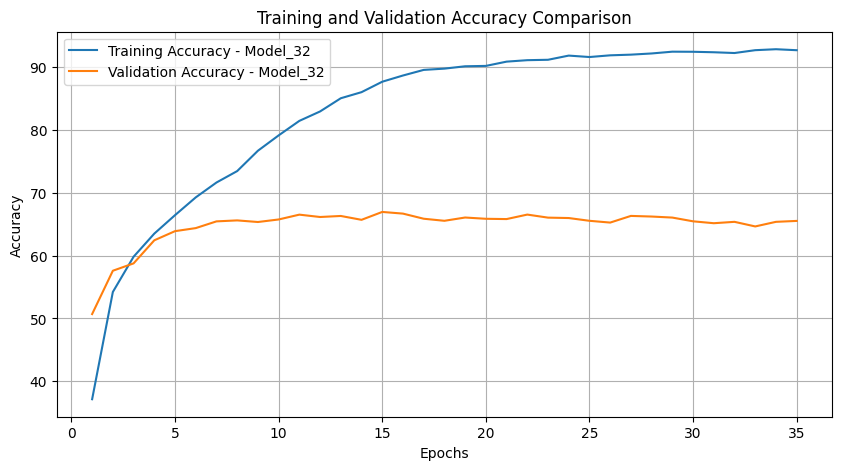

In [15]:
model_name ="Model_32"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_33

Since model_32 responded well to optimizer_18, but still overfitted quite a bit, we created a new optimizer by reducing beta 1 and doubling the weight decay to 0.001.

In [21]:
optimizer_19 = lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), weight_decay=0.001)

In [22]:
train_model(model=model_33, model_name="Model_33", criterion=criterion, optimizer=optimizer_19(model_33.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=10, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.5264272899836955, Accuracy: 42.668705043021504%
Validation Loss: 1.211941560632304, Accuracy: 54.67849629561877%
Epoch [2/200], Loss: 1.1687323974965134, Accuracy: 55.543795691969976%
Validation Loss: 1.2087764497737439, Accuracy: 54.0748193542486%
Epoch [3/200], Loss: 1.0650124200832882, Accuracy: 59.687187628623505%
Validation Loss: 1.0837118301475257, Accuracy: 58.98655446812403%
Epoch [4/200], Loss: 0.9965205507592347, Accuracy: 62.42331588953568%
Validation Loss: 0.9763237231830407, Accuracy: 63.29461264062929%
Epoch [5/200], Loss: 0.9316870157621497, Accuracy: 64.71844926598851%
Validation Loss: 0.941988241079955, Accuracy: 64.50196652336962%
Epoch [6/200], Loss: 0.8794281744097467, Accuracy: 66.79798514337234%
Validation Loss: 0.9475152532608189, Accuracy: 64.6117259672551%
Epoch [7/200], Loss: 0.833512184332157, Accuracy: 68.4698457497893%
Validation Loss: 0.9634779238561441, Accuracy: 64.41964694045551%
Epoch [8/200], Loss: 0.7911706819803364, Accuracy: 

([1.5264272899836955,
  1.1687323974965134,
  1.0650124200832882,
  0.9965205507592347,
  0.9316870157621497,
  0.8794281744097467,
  0.833512184332157,
  0.7911706819803364,
  0.7545349805706347,
  0.7170410124672618,
  0.6847241953622585,
  0.6573131946373882,
  0.6279438999285892,
  0.5942075411540961,
  0.5751578419186105,
  0.5499277111972014,
  0.5284575904237813,
  0.5138237327337265,
  0.49267149114496656,
  0.480489261817409,
  0.4671680837309099],
 [42.668705043021504,
  55.543795691969976,
  59.687187628623505,
  62.42331588953568,
  64.71844926598851,
  66.79798514337234,
  68.4698457497893,
  70.37886360518218,
  71.79592716724486,
  72.99935320750279,
  74.43993649673664,
  75.48068442406068,
  76.57239176025558,
  77.9443758452402,
  78.47552968385567,
  79.5868367926932,
  80.47862644793321,
  80.88630171890006,
  81.70753219262656,
  82.45820348483957,
  82.81099939240706],
 [1.211941560632304,
  1.2087764497737439,
  1.0837118301475257,
  0.9763237231830407,
  0.94198

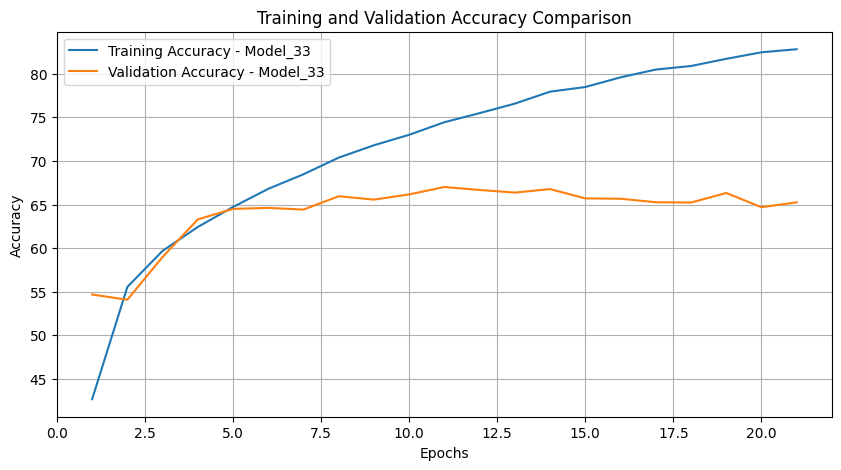

In [23]:
model_name ="Model_33"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

### Test the models

#### Test model_10

In [64]:
model_name = "Model 10"
evaluate_model(model_10, criterion, test_loader, device, model_name)

(1.7258722525068193, 67.23980245107006)

#### Test model_11

In [65]:
model_name = "Model 11"
evaluate_model(model_11, criterion, test_loader, device, model_name)

(1.1809447438221925, 65.73989390890799)

#### Test model_12_O2

In [67]:
model_name = "Model 12_O2"
evaluate_model(model_12, criterion, test_loader, device, model_name)

(1.8381950545903536, 68.12694347905615)

#### Test model_13

In [68]:
model_name = "Model 13"
evaluate_model(model_13, criterion, test_loader, device, model_name)

(1.7325461982199324, 67.18492774830803)

#### Test model_14

In [69]:
model_name = "Model 14"
evaluate_model(model_14, criterion, test_loader, device, model_name)

(1.8084962196343126, 67.67880007316627)

#### Test model_15

In [70]:
model_name = "Model 15"
evaluate_model(model_15, criterion, test_loader, device, model_name)

(1.850896861643819, 68.34644229010426)

#### Test model_16

In [91]:
model_name = "Model 16"
evaluate_model(model_16, criterion, test_loader, device, model_name)

(1.7548276694894533, 68.38302542527894)

#### Test model_17

In [32]:
model_name = "Model 17"
evaluate_model(model_17, criterion, test_loader, device, model_name)

(1.804955896578337, 67.89829888421438)

#### Test model_18

In [33]:
model_name = "Model 18"
evaluate_model(model_18, criterion, test_loader, device, model_name)

(1.6933060206516444, 67.23065666727639)

#### Test model_19

In [34]:
model_name = "Model 19"
evaluate_model(model_19, criterion, test_loader, device, model_name)

(1.534804760364064, 65.82220596305103)

#### Test model_20

In [35]:
model_name = "Model 20"
evaluate_model(model_20, criterion, test_loader, device, model_name)

(1.564953457193765, 64.76129504298518)

#### Test model_21

In [13]:
model_name = "Model 21"
evaluate_model(model_21, criterion, test_loader, device, model_name)

(1.1911024391999718, 60.3530272544357)

#### Test model_22

In [49]:
model_name = "Model 22"
evaluate_model(model_22, criterion, test_loader, device, model_name)

(2.079446720798113, 12.548015364916774)

#### Test model_23

In [21]:
model_name = "Model 23"
evaluate_model(model_23, criterion, test_loader, device, model_name)

(1.0792260405264402, 61.249314066215476)

The accuracy of this model is lower, but the loss is also much lower. Indeed, this model presents much less overfitting. It means we are going in the right direction.

#### Test model_24

In [28]:
model_name = "Model 24"
evaluate_model(model_24, criterion, test_loader, device, model_name)

(1.1709850113294278, 54.591183464422905)

#### Test model_25

In [47]:
model_name = "Model 25"
evaluate_model(model_25, criterion, test_loader, device, model_name)

(1.0760173991061093, 63.151637095299066)

#### Test model_26

In [54]:
model_name = "Model 26"
evaluate_model(model_26, criterion, test_loader, device, model_name)

(1.0605835010956604, 61.47795866105725)

#### Test model_27

In [21]:
model_name = "Model 27"
evaluate_model(model_27, criterion, test_loader, device, model_name)

(1.1825337253118817, 54.92043168099506)

#### Test model_28

In [22]:
model_name = "Model 28"
evaluate_model(model_28, criterion, test_loader, device, model_name)

(1.101015418419364, 60.37131882202305)

#### Test model_29

In [32]:
model_name = "Model 29"
evaluate_model(model_29, criterion, test_loader, device, model_name)

(1.1107525111813294, 61.304188768977504)

#### Test model_30

In [35]:
model_name = "Model 30"
evaluate_model(model_30, criterion, test_loader, device, model_name)

(1.582413961402854, 70.02012072434607)

#### Test model_31

In [36]:
model_name = "Model 31"
evaluate_model(model_31, criterion, test_loader, device, model_name)

(1.0315393608564523, 64.01134077190416)

#### Test model_32

In [16]:
model_name = "Model 32"
evaluate_model(model_32, criterion, test_loader, device, model_name)

(1.1524915749218032, 65.59356136820925)

#### Test model_33

In [25]:
model_name = "Model 33"
evaluate_model(model_33, criterion, test_loader, device, model_name)

(0.9023622004260794, 66.64532650448143)

### Table with the results of the different models

Before making our table we want to inspect the structure of the pickle files where we saved our accuracies. In this way we will know how to load the data.

In [73]:
# Function to inspect the structure of the pickle file
def inspect_pickle_file(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    print(f"Data from {pickle_file}:")
    print(data)
    return data

# Inspect one of the pickle files with the accuracies
sample_file_1 = 'Model_15_accuracies.pkl'
sample_file_2 = 'Model 15_test_results.pkl'
data_1 = inspect_pickle_file(sample_file_1)
data_2 = inspect_pickle_file(sample_file_2)

Data from Model_15_accuracies.pkl:
('Model_15', [26.99084690617589, 37.11608945336234, 46.60825934419161, 53.203582838439075, 57.53709256972619, 61.53740616608847, 64.96540640128575, 68.72268281687933, 72.12128339311263, 75.96479880833382, 78.84204543227298, 82.35628466709787, 85.35504988142138, 87.656063189667, 89.63368024930911, 91.14678269732072, 92.20517042002312, 93.17731914309795, 93.80843182219087, 94.41014484231982, 94.80214029517258, 95.49009231492914, 95.55477156464985, 95.95264694929539, 96.16432449383588, 96.49360067423218, 96.39168185649046, 96.84835655906392, 96.66999862801592, 96.87775621802787, 97.1031536034182, 97.1678328531389, 97.30699123890163, 97.22271221653828, 97.40891005664334, 97.56374826052017, 97.65390721467631, 97.64410732835499, 97.35795064777248, 97.92046412261618, 97.84206503204562, 97.66566707826189, 97.92242409988044, 97.88126457733091, 97.92830403167324, 97.90674428176634, 98.19682091687737, 97.85578487289547, 98.0870621900786, 98.09686207639992, 98.08

#### Load the data from the pickle files

In [26]:
# Function to load pickle file and get the highest accuracy
def get_best_accuracies(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    # Data is a tuple (model_name, training_accuracies, validation_accuracies)
    model_name, training_accuracies, validation_accuracies = data
    best_training_accuracy = max(training_accuracies)
    best_validation_accuracy = max(validation_accuracies)
    return best_training_accuracy, best_validation_accuracy

# Function to load pickle file and get the test accuracy and test loss
def get_test_results(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    # Data is a dictionary with 'test_accuracy' and 'test_losses' keys
    test_accuracy = data['test_accuracy']
    test_loss = data['test_loss']
    return test_accuracy, test_loss

# Load pickle files for each model
val_train_results = [
    'Model_10_accuracies.pkl',
    'Model_11_accuracies.pkl',
    'Model_12_O2_accuracies.pkl',
    'Model_13_accuracies.pkl',
    'Model_14_accuracies.pkl',
    'Model_15_accuracies.pkl',
    'Model_16_accuracies.pkl',
    'Model_17_accuracies.pkl',
    'Model_18_accuracies.pkl',
    'Model_19_accuracies.pkl',
    'Model_20_accuracies.pkl',
    'Model_21_accuracies.pkl',
    'Model_22_accuracies.pkl',
    'Model_23_accuracies.pkl',
    'Model_24_accuracies.pkl',
    'Model_25_accuracies.pkl',
    'Model_26_accuracies.pkl',
    'Model_27_accuracies.pkl',
    'Model_28_accuracies.pkl',
    'Model_29_accuracies.pkl',
    'Model_30_accuracies.pkl',
    'Model_31_accuracies.pkl',
    'Model_32_accuracies.pkl',
    'Model_33_accuracies.pkl'
]

# Load test results for each model
test_results = [
    'Model 10_test_results.pkl',
    'Model 11_test_results.pkl',
    'Model 12_O2_test_results.pkl',
    'Model 13_test_results.pkl',
    'Model 14_test_results.pkl',
    'Model 15_test_results.pkl',
    'Model 16_test_results.pkl',
    'Model 17_test_results.pkl',
    'Model 18_test_results.pkl',
    'Model 19_test_results.pkl',
    'Model 20_test_results.pkl',
    'Model 21_test_results.pkl',
    'Model 22_test_results.pkl',
    'Model 23_test_results.pkl',
    'Model 24_test_results.pkl',
    'Model 25_test_results.pkl',
    'Model 26_test_results.pkl',
    'Model 27_test_results.pkl',
    'Model 28_test_results.pkl',
    'Model 29_test_results.pkl',
    'Model 30_test_results.pkl',
    'Model 31_test_results.pkl',
    'Model 32_test_results.pkl',
    'Model 33_test_results.pkl'
]

# Load accuracies and test losses for each model
training_accuracies = []
validation_accuracies = []
test_accuracies = []
test_losses = []

for i, file in enumerate(val_train_results):
    train_acc, val_acc = get_best_accuracies(file)
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    test_acc, test_loss = get_test_results(test_results[i])
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

# Model names or identifiers (we are adding a +9 because our models start from #10)
model_names = [f"Model {9+i+1}" for i in range(len(val_train_results))]

# Print the accuracies and test losses
print("Training Accuracies:", training_accuracies)
print("Validation Accuracies:", validation_accuracies)
print("Test Accuracies:", test_accuracies)
print("Test Losses:", test_losses)



Training Accuracies: [97.76562591873935, 93.30667764253934, 98.929852413712, 98.24190039395543, 98.34381921169714, 98.51629721095236, 98.12234178083534, 98.36733893886831, 98.39085866603948, 95.99968640363772, 95.82132847258971, 78.21681268497285, 12.602653809215813, 68.27972795515572, 56.13178887124909, 76.68999039611141, 71.82924678073735, 56.03574998530017, 71.07857548852434, 75.86483996785637, 98.4222183022677, 82.89135846024186, 92.79120362203798, 82.81099939240706]
Validation Accuracies: [67.62096405378213, 66.18494466294705, 68.7825848349035, 68.6087990487515, 68.38013354065673, 69.70639348760633, 68.499039604866, 68.26122747644746, 68.34354705936157, 67.32827220342084, 66.08433183938534, 61.254916308424036, 12.658922528125858, 61.931766212384524, 55.016921247599015, 63.38607884386719, 62.443976950516785, 55.035214488246595, 60.97137107838654, 62.8098417634684, 70.75825482484223, 64.0446355071801, 66.92582090917406, 67.00814049208817]
Test Accuracies: [67.23980245107006, 65.7398

#### Print the table

In [27]:
# Creating the DataFrame
data = {
    "Model": model_names,
    "Training Accuracy": training_accuracies,
    "Validation Accuracy": validation_accuracies,
    "Test Accuracy": test_accuracies,
    "Test Loss": test_losses
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df)

       Model  Training Accuracy  Validation Accuracy  Test Accuracy  Test Loss
0   Model 10          97.765626            67.620964      67.239802   1.725872
1   Model 11          93.306678            66.184945      65.739894   1.180945
2   Model 12          98.929852            68.782585      68.126943   1.838195
3   Model 13          98.241900            68.608799      67.184928   1.732546
4   Model 14          98.343819            68.380134      67.678800   1.808496
5   Model 15          98.516297            69.706393      68.346442   1.850897
6   Model 16          98.122342            68.499040      68.383025   1.754828
7   Model 17          98.367339            68.261227      67.898299   1.804956
8   Model 18          98.390859            68.343547      67.230657   1.693306
9   Model 19          95.999686            67.328272      65.822206   1.534805
10  Model 20          95.821328            66.084332      64.761295   1.564953
11  Model 21          78.216813            61.254916

### Confusion matrix of the best models

#### Model 26

This model presents much less overfittin than the previous models, but without losing too much accuracy and keeping it above 60%. The loss is also very low compared to the other models (1.06).

In [40]:
#Re-define the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [41]:
# Load the best model weights
model_path = 'Model_26_best_model.pth'
model_26 = CNNModel()
model_26.load_state_dict(torch.load(model_path))
model_26.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_ru

In [42]:
# Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_26.to(device)

# Summarize the model
summary(model_26, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

In [43]:
true_labels = []
predicted_labels = []

#Re-define val_loader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_26(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())  # Move to CPU before converting to numpy
        predicted_labels.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


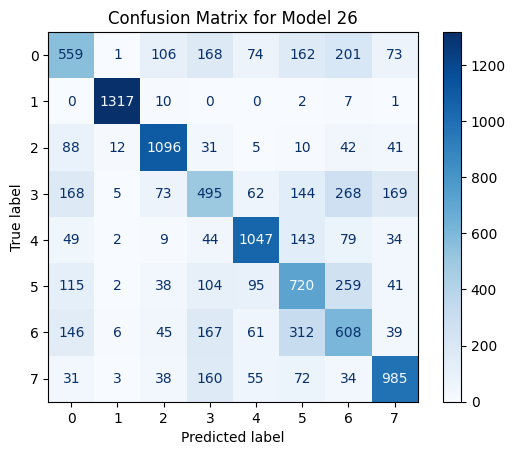

In [44]:
#Specify the model (for the title)
model_name = "Model 26"

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(8)])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

Very nice, but the labels are not clear when displayed in a numeric format, so let's add the string versions of the labels.

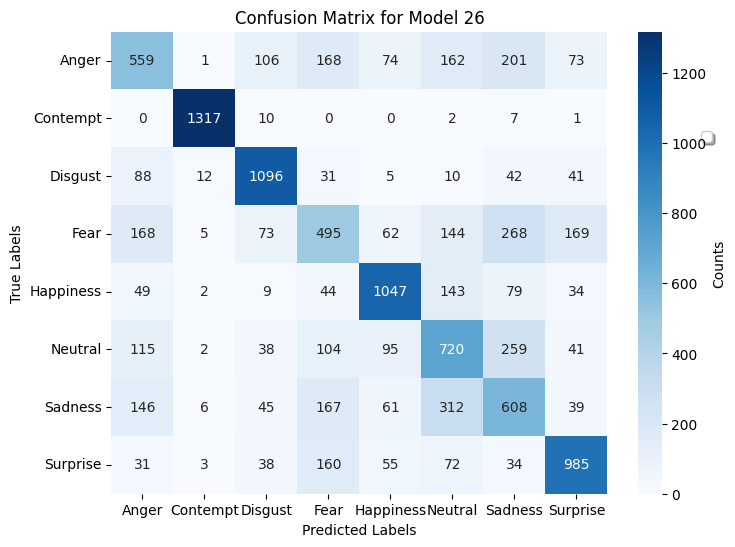

In [46]:
#Specify the model (for the title)
model_name = "Model 26"

# Label mapping
label_mapping = {
    0: 'Anger',
    1: 'Contempt',
    2: 'Disgust',
    3: 'Fear',
    4: 'Happiness',
    5: 'Neutral',
    6: 'Sadness',
    7: 'Surprise'
}

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())

plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#Get the current Axes object from the plot
ax = plt.gca()

# Create a colorbar based on the mappable (heatmap)
cbar = ax.collections[0].colorbar
cbar.set_label('Counts')

# Add legend
plt.legend(label_mapping.values(), loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)

plt.show()

The line that cuts the matrix in two shows that most classes were guessed right. However, reaching only around 60% accuracy, the model still has a long way to go. However, being a classification problem with 8 classes, missclassifications of classes compounds, leading to a higher error in the end, compared to what a binary or ternary classification problem would lead.

Said that we can see some patterns in the missclassifications. These patterns can tell us different things:
- If certain emotions were difficult to distinguish by the machine, either because of poor data quality or because those emotions are difficult to distinguish in real life too.
- If the emotions that were missclassified the most are difficult to distinguish in real life too, it means that it is not entirely the model's fault if they were missclassified.

Most common missclassified emotions:

- For example sadness and neutral emotions are the most missclassified. If we look at the images, they have many similarity, and missing microexpression will lead to missclassification between the two. Also if sadness or neutrality was not represented showing microexpressions, that would hae lead to missclassification. Therefore, taking the neutral class of the dataset, would lead a very high increment in accuracy.
- Fear and sadness are mistaken a lot, it makes sense into a certain exent, but the representation of the emotion is not that similar. Therefore, this limitation is either a problem of the model or the dataset. The same holds for anger and sadness and anger and fear. Also  the missclassification between anger and neutral are abnormal.
- The missclassifications between fear and surprise somehow make sense, especially in the case of mixed emotions in the photos.

#### Model 24

In [47]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [48]:
# Load the best model weights
model_path = 'Model_24_best_model.pth'
model_24 = CNNModel()
model_24.load_state_dict(torch.load(model_path))
model_24.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_ru

In [49]:
# Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_24.to(device)

# Summarize the model
summary(model_24, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

In [50]:
true_labels = []
predicted_labels = []

#Re-define val_loader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_24(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())  # Move to CPU before converting to numpy
        predicted_labels.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

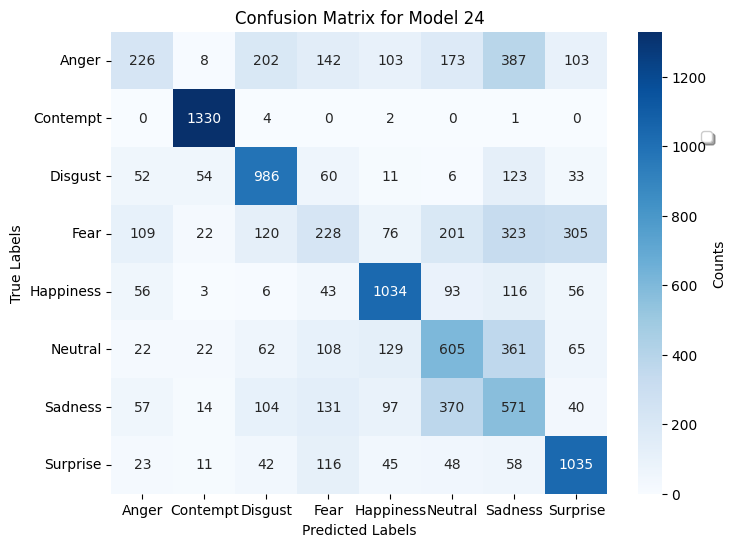

In [51]:
#Specify the model (for the title)
model_name = "Model 24"

# Label mapping
label_mapping = {
    0: 'Anger',
    1: 'Contempt',
    2: 'Disgust',
    3: 'Fear',
    4: 'Happiness',
    5: 'Neutral',
    6: 'Sadness',
    7: 'Surprise'
}

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())

plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#Get the current Axes object from the plot
ax = plt.gca()

# Create a colorbar based on the mappable (heatmap)
cbar = ax.collections[0].colorbar
cbar.set_label('Counts')

# Add legend
plt.legend(label_mapping.values(), loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)

plt.show()

Also here the model missclassifies sadness for neutrality frequently, and viceversa. Also fear is being missclassified for sadness and anger for sadness. Fear is missclassified for surrprise, which makes sense. However, here anger and fear have a very low score in term of correctly identified sample. Therefore we can see how this model is of lower quality compared to Model 26, even if it presents with lower overfitting (or virtually no overfitting).

#### Model 31

In [52]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.out = nn.Linear(128, 8)  # Change the number of output channels to 8
        
    def forward(self, x):
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.elu(self.bn5(self.conv5(x)))
        x = F.elu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.elu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.out(x)
        
        return x

In [53]:
# Load the best model weights
model_path = 'Model_31_best_model.pth'
model_31 = CNNModel()
model_31.load_state_dict(torch.load(model_path))
model_31.eval()

CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [54]:
# Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_31.to(device)

# Summarize the model
summary(model_31, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 48, 48]             640
       BatchNorm2d-2            [1, 64, 48, 48]             128
            Conv2d-3            [1, 64, 48, 48]          36,928
       BatchNorm2d-4            [1, 64, 48, 48]             128
         MaxPool2d-5            [1, 64, 24, 24]               0
           Dropout-6            [1, 64, 24, 24]               0
            Conv2d-7           [1, 128, 24, 24]          73,856
       BatchNorm2d-8           [1, 128, 24, 24]             256
            Conv2d-9           [1, 128, 24, 24]         147,584
      BatchNorm2d-10           [1, 128, 24, 24]             256
        MaxPool2d-11           [1, 128, 12, 12]               0
          Dropout-12           [1, 128, 12, 12]               0
           Conv2d-13           [1, 256, 12, 12]         295,168
      BatchNorm2d-14           [1,

In [55]:
true_labels = []
predicted_labels = []

#Re-define val_loader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_31(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())  # Move to CPU before converting to numpy
        predicted_labels.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

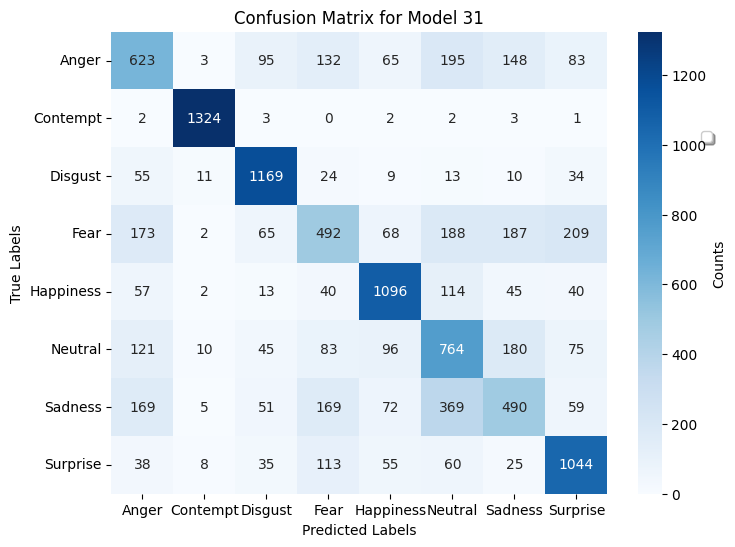

In [56]:
#Specify the model (for the title)
model_name = "Model 31"

# Label mapping
label_mapping = {
    0: 'Anger',
    1: 'Contempt',
    2: 'Disgust',
    3: 'Fear',
    4: 'Happiness',
    5: 'Neutral',
    6: 'Sadness',
    7: 'Surprise'
}

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())

plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#Get the current Axes object from the plot
ax = plt.gca()

# Create a colorbar based on the mappable (heatmap)
cbar = ax.collections[0].colorbar
cbar.set_label('Counts')

# Add legend
plt.legend(label_mapping.values(), loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)

plt.show()

This model does a very good job with most labels, even if it presented much more overfitting compared to the other two. There is still a misslassification problem, especially saness is often missclassified as neutrality, and neutrality is often missclassified as sadness, even if much less, this time. This model has a lower score with disgust and sadness, compared to Model 24, but it has also a much lower number of false postives with neutral and sadness. The performance of this model is very similar to Model 26, but sadness is being identified much more accurately in the latter, and it looks like Model 26 is a bit biased toward sadness, because also neutrality is being classified as sedness significantly more often. Model 26 tends to over represent sadness, and it mistakes dear for sadness also more often, but it it's more accurated in identify fear versus the other emotions.

#### Model 33

In [28]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.out = nn.Linear(128, 8)  # Change the number of output channels to 8
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.out(x)
        
        return x

In [29]:
# Load the best model weights
model_path = 'Model_33_best_model.pth'
model_33 = CNNModel()
model_33.load_state_dict(torch.load(model_path))
model_33.eval()

CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [30]:
# Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_33.to(device)

# Summarize the model
summary(model_33, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 48, 48]             640
       BatchNorm2d-2            [1, 64, 48, 48]             128
            Conv2d-3            [1, 64, 48, 48]          36,928
       BatchNorm2d-4            [1, 64, 48, 48]             128
         MaxPool2d-5            [1, 64, 24, 24]               0
           Dropout-6            [1, 64, 24, 24]               0
            Conv2d-7           [1, 128, 24, 24]          73,856
       BatchNorm2d-8           [1, 128, 24, 24]             256
            Conv2d-9           [1, 128, 24, 24]         147,584
      BatchNorm2d-10           [1, 128, 24, 24]             256
        MaxPool2d-11           [1, 128, 12, 12]               0
          Dropout-12           [1, 128, 12, 12]               0
           Conv2d-13           [1, 256, 12, 12]         295,168
      BatchNorm2d-14           [1,

In [31]:
true_labels = []
predicted_labels = []

#Re-define val_loader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_33(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())  # Move to CPU before converting to numpy
        predicted_labels.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

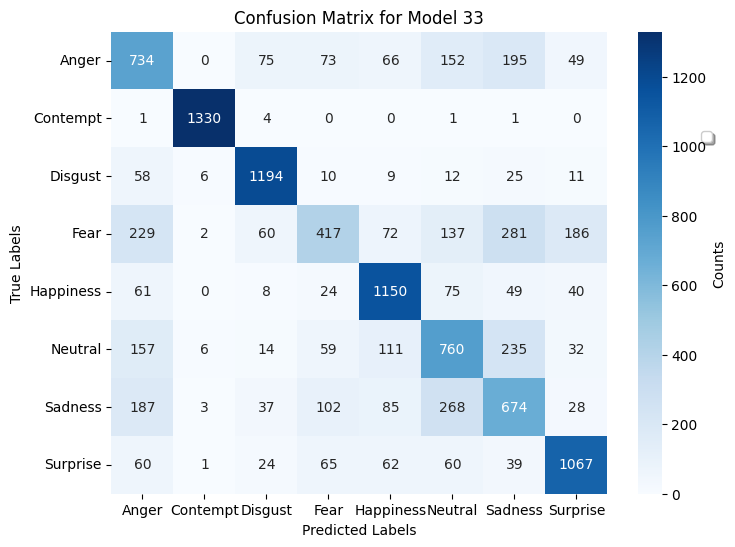

In [32]:
#Specify the model (for the title)
model_name = "Model 33"

# Label mapping
label_mapping = {
    0: 'Anger',
    1: 'Contempt',
    2: 'Disgust',
    3: 'Fear',
    4: 'Happiness',
    5: 'Neutral',
    6: 'Sadness',
    7: 'Surprise'
}

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())

plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#Get the current Axes object from the plot
ax = plt.gca()

# Create a colorbar based on the mappable (heatmap)
cbar = ax.collections[0].colorbar
cbar.set_label('Counts')

# Add legend
plt.legend(label_mapping.values(), loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)

plt.show()

This looks to be our best model so far. Not only it has the highest test accuracy and the lower loss (below 1), but it also presents fewer signs of overfitting, thanks to the higher weight decay.
Most classes were idenfified correctly, and th eclassification look more balanced. However, there are still many missclassification (apart from neutrality Vs sadness), such as anger mistaken for neutrality or sadness, and viceversa, and fear istake by neutrality, sadness, and surprise (the latter makes sense in the case of mixed emotions, since often fear is triggered by a scary surprise). Some of the missclassifications, like neutrality Vs sadness, anger Vs sadness or neutrality could have happened because in the dataset some expressions of anger were very subtle and presented many of the caracteristics of neutrality, with differences only in the microexpressions.

## Conclusions

### Observations

Our best models were:
- [Model 26](#model-26): Training Acc: 71.829247, Vall Acc: 62.443977, Test Acc: 61.477959, Test loss: 1.060584
- [Model 33](#model-33): Training Acc: 82.810999, Vall Acc: 67.008140, Test Acc: 66.645327, Test loss: 0.902362

As we can see Model 33 learn significantly more, it has a higher test accuracy and lower test loss. However, Model 26 show a smaller gap between training test accuracy, which indicates less overfitting. However, looking at the plots of both models ([Model 26](#train-model_26), [Model 33](#train-model_33)), they both look like they are doing well in term of overfitting (i.e., Model 33 curve is not too smooth, and takes a while in the beginning to reach the elbow point).

The accuracy of these models is not stellar, however, considering that it's an image classification task comprehending 8 classes, every error and missclassification compound and greatly reduce accuracy. If the task would have been a binary or ternary classification (with some small tweaks in the output channels), it would have performed much better. Moreover, some classes were hard to distinguish sometimes, both because of the data and because they are tricky to distinguish also for humans (sadness Vs neutrality, anger Vs neutrality, anger Vs fear, fear Vs surprise), also because the presence of mixed emotions and reliance on microexpressions.

Accordingly the most interesting results were found in the analysis of the confusions matrices though, and [you can find them here](#confusion-matrix-of-the-best-models).

### Lessons learned

We trained and tested 8 separate model to find out that:
1. Adding too many hidden layers reduced the performance of the model, but adding none made the model more prone to overfitting.
2. Reducing the number of convolutional layers reduced the test accuracy.
3. We tried 0.1, 0.25, and 0.5 dropout rates, and 0.25 worked best in our models.
4. Hyperparameter tuning was fundamental in improving the performance of our models. We slightly increased the learning rate to improve the model converge, even if it lead to lower stability. On the other hand, we incremented significantly the weight decay. We also increased beta 1 to give some momentum to the model and avoid having it stuck into a local minima.

In the future we should considering using random search at first and then grid search to automatically fine tune hyperparamentes. Indeed, this is what took the most time, and finetuning hyperparameters that way would have saved us many tests. Moreover, if we have greatly improved our models' performance and explored several combinations, we have probably haven't reached the best hypermarameters combination for the optimizer. We have not implemented random or greed search because a CNN for image classificaton can be computationally expensive to fine tune that way, especially if we consider grid search. However, that was a mistake and we should have tried that from the beginning.

We have trained different models of different complexities and we found out that more complex models don't necessarily perform better for our dataset.
Another hyperparameter we fine tuned is patience. We found out that patience worked best at 10, even if we trained some models with 20 patience, because they had a higher weight decay and were slower to train. However, increasing patience leads also to more overfittin.

Our best models are 26 and 31, with the first one having a much higher number of trainable parameters. They both overfitted a bit, but had a significant loss that other models. Model 31 converged a bit too fast, which can be a sign of overfitting, but looking at the confusion matrix, it presented valid results. Model 26 was a bit biased toward the identification of sadness and got more false negatives in other emotions that were classified as sadness, especially with neutrality. But it also got more true positives with sadness. In both models sadness and neutrality were the most missclassified emotions, and it makes sense, because they are pretty similar. Other emotions presented a pattern of missclassification, learn more on our [description of the confusion matrices](#confusion-matrix-of-the-best-models).

### Limitations with the data

The data is one of the  major bottlenecks in this experiemnt. As said in the first notebook of the series, if there are missclassified images in the original data, that may lead to errors in the training. Also, mixed emotions (e.g., surprise + fear, surprise + happiness) can confuse the model as well. Also the fact that some emotions have similar traits made the learning process more difficult (e.g., Neutral Vs Sadness), and it would be useful to use this generic model as a base model to train more specialized models aimed at detecting the difference between such emotions (through the identification of microexpressions).

Another challenge was that the majority of images were images portraing actors interpreting an emotion. While it looks like the majortiy of good actors did a good job in displaying the emotion, some representation may not have looked authentic, with incomplete and to genuine microexpressions. To reduce the risk of encountering these two challenges we could access to bigger datasets (to increasing the chance of good samples outnumbering bad samples), and higher quality more controlled datasets. A further study could also take the output model from this study and use it as a pre-trained model to classify genuine Vs faked emotions from pictures.

When loading the data we removed duplicates, mixed data from different sources (increasing the variance in gender, etnic diversity, angles, and styles), and augmented data to reduce overfitting and balance the classes, so each class got the same amount of items. However, we did not aumented the images from the "Happiness" folder, because it had the most items, so further study could do some augmentation there too to reduce overfitting (still making sure that each label has the same number of items).

As future steps we should try adding more images through data augmentation, and test if that helps in reducing overfitting. We could also experiment removing neutrality, our most mistaken class (mistaken for sadness and viceversa), and see how accuracy dramatically increases. However, by removing a class, we would also drastically change the goal of our models. Also, by removing neutrality, if the model was to be applied in a life scenarion, it would start mistake neutral expression for sadness.

### Next steps

To summarise our next steps, we should defenitely try to use random seach and or grid search to fine tune hyperparameters, since they have such a big impact on the training process. Moreover, we should try also implementing more data augmentation to see how the models react to more augmented data. On the other hand, since the elements in some classes got agumented much more than others, too much data augmentation could lead to too many duplicates of images in some classes. However, we see that contempt and disgust, the most augmented classes, were also the most accurate. Moreover, they had very little missclassification between each other, even if the two emotions may look similar in some cases. This is a point in favour of data augmentaiton, and we should defenitely try adding more.